# Question 1

#### 0. Create Model and Load Dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn.init as init

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('available device:', device)

available device: cuda


In [ ]:
# Hyperparameters
BATCH_SIZE = 64
NUM_WORKERS = 2
VALIDATION_SPLIT = 0.1  # 10% of training data for validation

transform = transforms.ToTensor()

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

train_size = int((1 - VALIDATION_SPLIT) * len(trainset))
val_size = len(trainset) - train_size
train_subset, val_subset = random_split(trainset, [train_size, val_size])

trainloader = DataLoader(dataset=train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valloader = DataLoader(dataset=val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(dataset=testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Training set size: {len(train_subset)}")
print(f"Validation set size: {len(val_subset)}")
print(f"Test set size: {len(testset)}")


100%|██████████| 170M/170M [00:08<00:00, 20.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training set size: 45000
Validation set size: 5000
Test set size: 10000


In [6]:
class Model(nn.Module):
    def __init__(self, k1, k2, is_dropout=False, is_batch=False, dp=0.2, input_size=(3, 32, 32)):
        super(Model, self).__init__()  # Properly initialize nn.Module

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=k1, stride=1)

        self.pool1 = nn.AvgPool2d(kernel_size=3, stride=1, padding=0)

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=k2, stride=1, padding=1)

        self.pool2 = nn.AvgPool2d(kernel_size=3, stride=1, padding=0)

        # Dropout and BatchNorm options
        self.is_dropout = is_dropout
        self.is_batch = is_batch
        self.dropout = nn.Dropout3d(p=dp)
        self.batch_norm1 = nn.BatchNorm2d(num_features=8)
        self.batch_norm2 = nn.BatchNorm2d(num_features=16)

        self.flatten_dim = self._calculate_flatten_dim(input_size)

        # Fully connected layers
        self.fc1 = nn.Linear(in_features=self.flatten_dim, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)
        self._initialize_weights()


    def _calculate_dim(self, n, k, p, s):
        """
        Helper method to calculate the spatial dimensions after a convolution or pooling layer.
        Args:
        - n (int): Input dimension (height or width)
        - k (int): Kernel size
        - p (int): Padding
        - s (int): Stride
        Returns:
        - int: Output dimension
        """
        return int((n - k + 2 * p) / s) + 1

    def _calculate_flatten_dim(self, input_size):
        """
        Calculates the flattened dimension of the feature map after all convolutional and pooling layers.
        Args:
        - input_size (tuple): Input size in the form (channels, height, width)
        Returns:
        - int: Flattened dimension
        """
        c, h, w = input_size

        # First convolutional layer
        h = self._calculate_dim(h, self.conv1.kernel_size[0], self.conv1.padding[0], self.conv1.stride[0])
        w = self._calculate_dim(w, self.conv1.kernel_size[1], self.conv1.padding[1], self.conv1.stride[1])

        # First pooling layer
        h = self._calculate_dim(h, self.pool1.kernel_size, 0, self.pool1.stride)
        w = self._calculate_dim(w, self.pool1.kernel_size, 0, self.pool1.stride)

        # Second convolutional layer
        h = self._calculate_dim(h, self.conv2.kernel_size[0], self.conv2.padding[0], self.conv2.stride[0])
        w = self._calculate_dim(w, self.conv2.kernel_size[1], self.conv2.padding[1], self.conv2.stride[1])

        # Second pooling layer
        h = self._calculate_dim(h, self.pool2.kernel_size, 0, self.pool2.stride)
        w = self._calculate_dim(w, self.pool2.kernel_size, 0, self.pool2.stride)

        # Final flattened dimension
        return 16 * h * w  # 16 is the output channels of the second convolutional layer


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                init.zeros_(m.bias)

    def forward(self, X):
        X = self.conv1(X)
        if self.is_batch:
            X = self.batch_norm1(X)
        X = F.relu(X)
        X = self.pool1(X)

        X = self.conv2(X)
        if self.is_batch:
            X = self.batch_norm2(X)
        X = F.relu(X)
        X = self.pool2(X)

        # Apply dropout if enabled
        if self.is_dropout:
            X = self.dropout(X)

        # Flatten the tensor to feed into the fully connected layers
        X = torch.flatten(X, start_dim=1)

        # Fully connected layers
        X = F.relu(self.fc1(X))
        X = self.fc2(X)

        return X  # Return raw logits


In [4]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import LinearLR, MultiStepLR, ReduceLROnPlateau
import time
import pandas as pd

In [5]:
def train(model, trainloader, valloader, threshold=0.3, lr=0.01, epochs=200, is_dynamic_lr=False, lr_schedule=None):
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # Suitable for softmax outputs
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Optional Learning Rate Scheduler
    scheduler = None
    if is_dynamic_lr and lr_schedule:
        if lr_schedule['type'] == 'LinearLR':
            scheduler = LinearLR(optimizer, **lr_schedule['params'])
        elif lr_schedule['type'] == 'MultiStepLR':
            scheduler = MultiStepLR(optimizer, **lr_schedule['params'])
        elif lr_schedule['type'] == 'ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, **lr_schedule['params'])
        else:
            raise ValueError(f"Unsupported LR scheduler type: {lr_schedule['type']}")

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_train_loss = 0.0

        for inputs, labels in trainloader:
            # Move data to the device (GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate training loss
            running_train_loss += loss.item()

        # Compute average training loss for this epoch
        avg_train_loss = running_train_loss / len(trainloader)
        train_losses.append(avg_train_loss)

        # Validation loop
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

        # Compute average validation loss for this epoch
        avg_val_loss = running_val_loss / len(valloader)
        val_losses.append(avg_val_loss)

        # Adjust learning rate using scheduler
        if scheduler:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(avg_val_loss)  # ReduceLROnPlateau needs the validation loss
            else:
                scheduler.step()  # Step for other schedulers

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Early stopping if validation loss is below threshold
        if avg_val_loss < threshold:
            print(f"Early stopping: Validation loss below threshold ({threshold})")
            print(f"Final Train Loss: {avg_train_loss:.4f}, Final Val Loss: {avg_val_loss:.4f}")
            print(f"Training stopped at epoch {epoch+1}")
            break

    return train_losses, val_losses


def evaluate_and_plot(model, testloader, train_losses, val_losses):
    # Set model to evaluation mode
    model.eval()

    # Predictions and ground truths
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=testloader.dataset.classes)
    print("\nClassification Report:\n", report)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=testloader.dataset.classes, yticklabels=testloader.dataset.classes)
    plt.title("Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

    # Plot training and validation loss
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=epochs, y=train_losses, label="Train Loss")
    sns.lineplot(x=epochs, y=val_losses, label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


## 1. Experiments


##### 1.1 Kernel size

Testing kernel sizes: Conv1=3, Conv2=3
Epoch 1/30, Train Loss: 1.5711, Val Loss: 1.2902, LR: 0.001000
Epoch 2/30, Train Loss: 1.2342, Val Loss: 1.1840, LR: 0.001000
Epoch 3/30, Train Loss: 1.0885, Val Loss: 1.1239, LR: 0.001000
Epoch 4/30, Train Loss: 0.9792, Val Loss: 1.1281, LR: 0.001000
Epoch 5/30, Train Loss: 0.8832, Val Loss: 1.0777, LR: 0.001000
Epoch 6/30, Train Loss: 0.7963, Val Loss: 1.0716, LR: 0.001000
Epoch 7/30, Train Loss: 0.7130, Val Loss: 1.0980, LR: 0.001000
Epoch 8/30, Train Loss: 0.6392, Val Loss: 1.1453, LR: 0.001000
Epoch 9/30, Train Loss: 0.5675, Val Loss: 1.2551, LR: 0.001000
Epoch 10/30, Train Loss: 0.5060, Val Loss: 1.2551, LR: 0.001000
Epoch 11/30, Train Loss: 0.4434, Val Loss: 1.3065, LR: 0.001000
Epoch 12/30, Train Loss: 0.3931, Val Loss: 1.4159, LR: 0.001000
Epoch 13/30, Train Loss: 0.3414, Val Loss: 1.4635, LR: 0.001000
Epoch 14/30, Train Loss: 0.2984, Val Loss: 1.5681, LR: 0.001000
Epoch 15/30, Train Loss: 0.2679, Val Loss: 1.6462, LR: 0.001000
Epoch 16/3

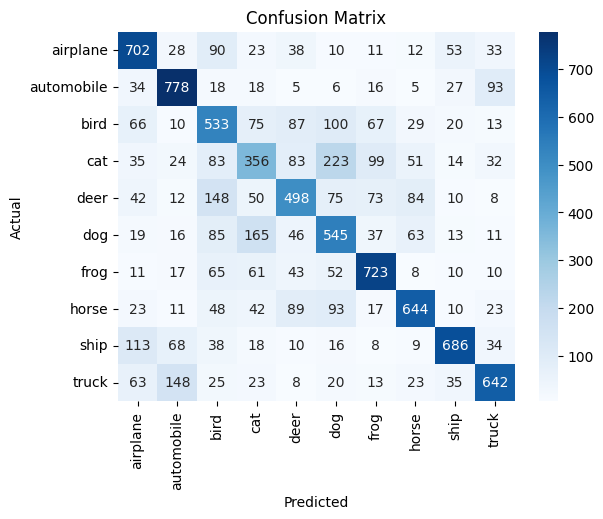

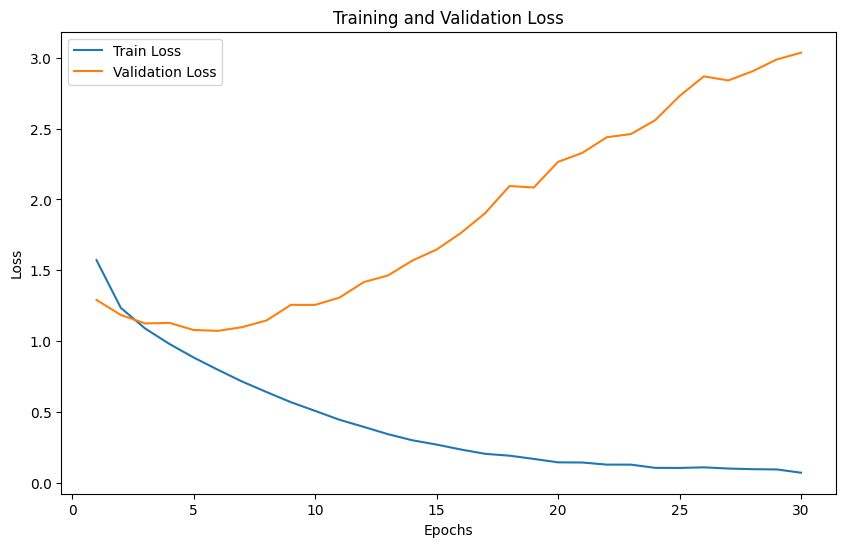

Testing kernel sizes: Conv1=5, Conv2=5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/30, Train Loss: 1.6119, Val Loss: 1.3732, LR: 0.001000
Epoch 2/30, Train Loss: 1.2846, Val Loss: 1.2434, LR: 0.001000
Epoch 3/30, Train Loss: 1.1360, Val Loss: 1.2034, LR: 0.001000
Epoch 4/30, Train Loss: 1.0343, Val Loss: 1.1987, LR: 0.001000
Epoch 5/30, Train Loss: 0.9357, Val Loss: 1.1810, LR: 0.001000
Epoch 6/30, Train Loss: 0.8413, Val Loss: 1.1606, LR: 0.001000
Epoch 7/30, Train Loss: 0.7609, Val Loss: 1.2088, LR: 0.001000
Epoch 8/30, Train Loss: 0.6651, Val Loss: 1.3434, LR: 0.001000
Epoch 9/30, Train Loss: 0.5943, Val Loss: 1.4356, LR: 0.001000
Epoch 10/30, Train Loss: 0.5170, Val Loss: 1.4861, LR: 0.001000
Epoch 11/30, Train Loss: 0.4584, Val Loss: 1.5184, LR: 0.001000
Epoch 12/30, Train Loss: 0.3893, Val Loss: 1.8578, LR: 0.001000
Epoch 13/30, Train Loss: 0.3513, Val Loss: 1.7771, LR: 0.001000
Epoch 14/30, Train Loss: 0.3017, Val Loss: 1.7756, LR: 0.001000
Epoch 15/30, Train Loss: 0.2559, Val Loss: 2.0709, LR: 0.001000
Epoch 16/30, Train Loss: 0.2392, Val Loss: 2.1135

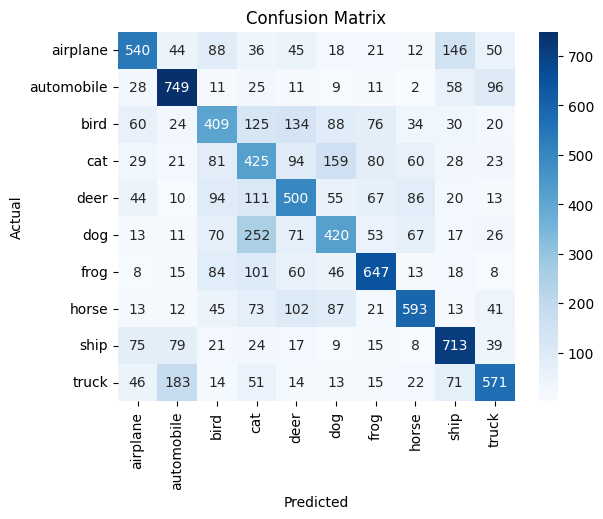

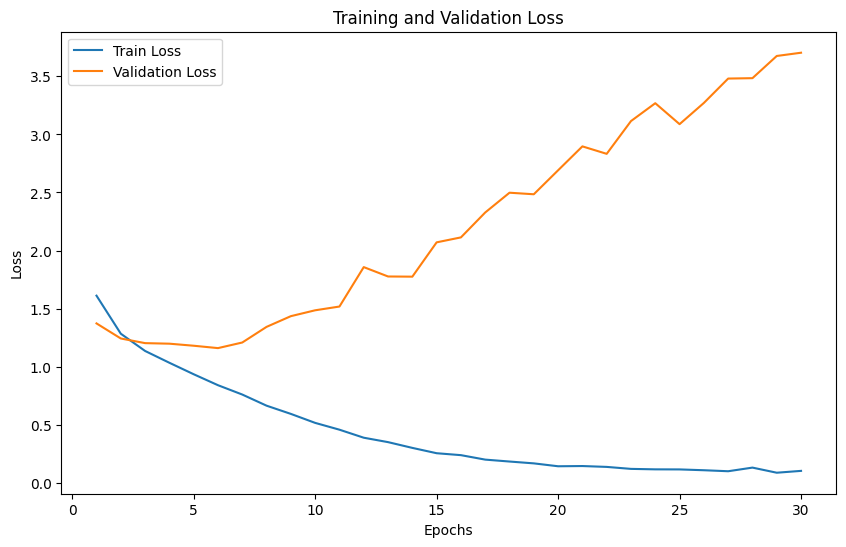

Testing kernel sizes: Conv1=7, Conv2=7


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/30, Train Loss: 1.8105, Val Loss: 1.5628, LR: 0.001000
Epoch 2/30, Train Loss: 1.5067, Val Loss: 1.5262, LR: 0.001000
Epoch 3/30, Train Loss: 1.3893, Val Loss: 1.3597, LR: 0.001000
Epoch 4/30, Train Loss: 1.2977, Val Loss: 1.3468, LR: 0.001000
Epoch 5/30, Train Loss: 1.2160, Val Loss: 1.3443, LR: 0.001000
Epoch 6/30, Train Loss: 1.1370, Val Loss: 1.3077, LR: 0.001000
Epoch 7/30, Train Loss: 1.0762, Val Loss: 1.2647, LR: 0.001000
Epoch 8/30, Train Loss: 1.0099, Val Loss: 1.3189, LR: 0.001000
Epoch 9/30, Train Loss: 0.9470, Val Loss: 1.3423, LR: 0.001000
Epoch 10/30, Train Loss: 0.8809, Val Loss: 1.3703, LR: 0.001000
Epoch 11/30, Train Loss: 0.8227, Val Loss: 1.3760, LR: 0.001000
Epoch 12/30, Train Loss: 0.7601, Val Loss: 1.4294, LR: 0.001000
Epoch 13/30, Train Loss: 0.7167, Val Loss: 1.5195, LR: 0.001000
Epoch 14/30, Train Loss: 0.6651, Val Loss: 1.5964, LR: 0.001000
Epoch 15/30, Train Loss: 0.6109, Val Loss: 1.6684, LR: 0.001000
Epoch 16/30, Train Loss: 0.5728, Val Loss: 1.7691

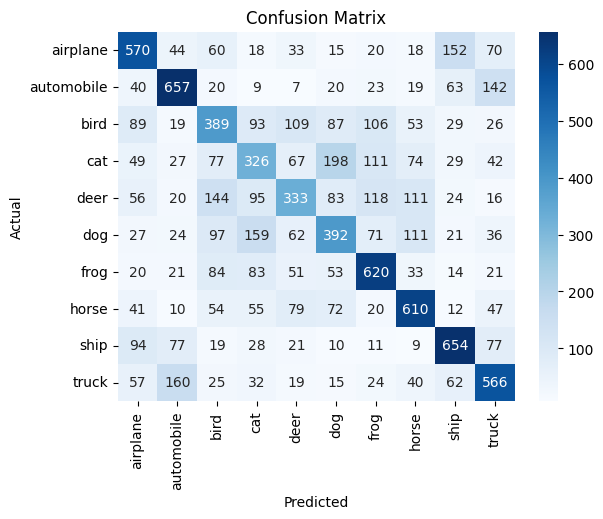

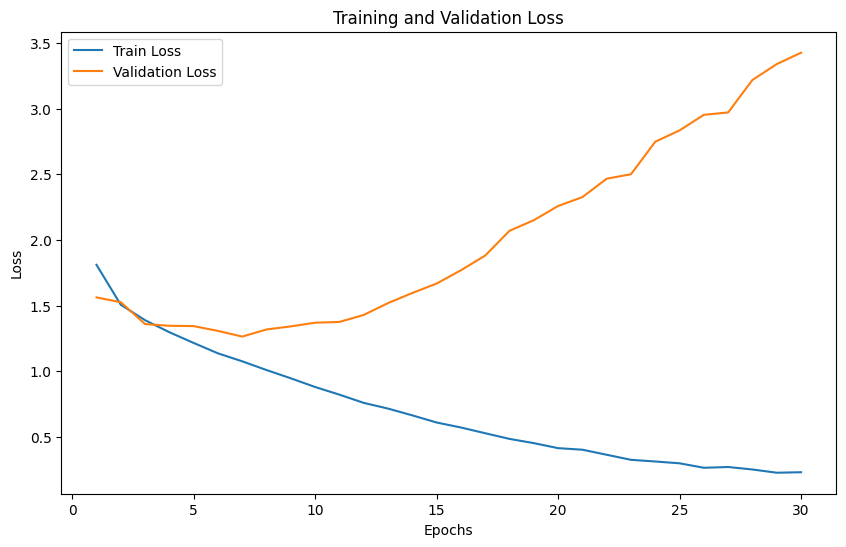


Experiment Results:
   Conv1 Kernel  Conv2 Kernel  Train Loss  Val Loss    Time (s)  Memory (MB)
0             3             3    0.069100  3.036982  322.425462   108.439040
1             5             5    0.103887  3.703083  312.830946    97.911296
2             7             7    0.232529  3.424504  307.448098    97.159168


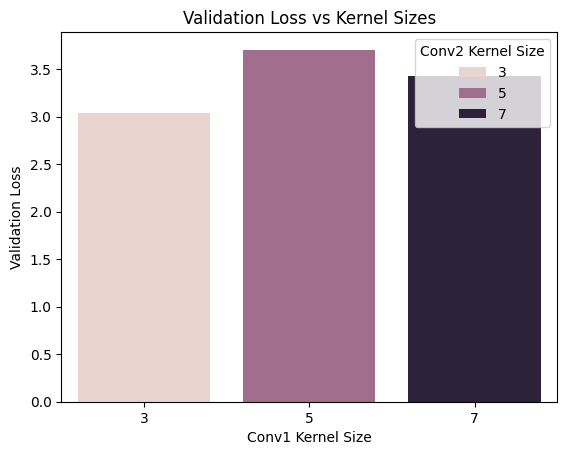

In [ ]:
kernel_sizes = [(3, 3), (5, 5), (7, 7)]  # Different kernel sizes for conv1 and conv2
epochs = 30
lr = 0.001

# Record results
results = []

for k1, k2 in kernel_sizes:
    print(f"Testing kernel sizes: Conv1={k1}, Conv2={k2}")

    # Initialize the model with the specified kernel sizes
    model = Model(k1, k2).to(device)

    # Train the model and record memory usage
    start_time = time.time()
    train_losses, val_losses = train(model, trainloader, valloader, lr=lr, epochs=epochs)
    end_time = time.time()

    # Evaluate and plot results
    print(f"Evaluating model for Conv1={k1}, Conv2={k2}...")
    evaluate_and_plot(model, testloader, train_losses, val_losses)

    # Measure GPU memory usage if CUDA is available
    memory_usage = torch.cuda.max_memory_allocated(device) / 1e6 if torch.cuda.is_available() else "N/A"

    # Record results
    results.append({
        "Conv1 Kernel": k1,
        "Conv2 Kernel": k2,
        "Train Loss": train_losses[-1],
        "Val Loss": val_losses[-1],
        "Time (s)": end_time - start_time,
        "Memory (MB)": memory_usage
    })

    # Reset GPU memory if CUDA is available
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results in tabular format
print("\nExperiment Results:")
print(results_df)

# Plot kernel sizes vs validation loss
sns.barplot(x="Conv1 Kernel", y="Val Loss", hue="Conv2 Kernel", data=results_df)
plt.title("Validation Loss vs Kernel Sizes")
plt.ylabel("Validation Loss")
plt.xlabel("Conv1 Kernel Size")
plt.legend(title="Conv2 Kernel Size")
plt.show()


#### 1.1.1 Results and conclusion
### **Impact of Kernel Sizes on Model Performance**

| **Conv1 Kernel** | **Conv2 Kernel** | **Train Loss** | **Val Loss** | **Time (s)** | **Memory (MB)** |
|-------------------|-------------------|----------------|--------------|--------------|-----------------|
| 3                | 3                | 0.0691         | 3.036982     | 322.43       | 108.44          |
| 5                | 5                | 0.1039         | 3.703083     | 312.83       | 97.91           |
| 7                | 7                | 0.2325         | 3.424504     | 307.45       | 97.16           |

#### **Charts**

1. **Validation Loss vs Kernel Sizes**
   ![Validation Loss Chart](#)
   *(check the validation loss vs kernel size above)*

---

### **Conclusions**

- **Performance**: Smaller kernels (3x3) achieved the best performance with the lowest validation loss (3.036982). Larger kernels (5x5 and 7x7) resulted in higher losses, indicating reduced effectiveness in capturing finer features required for classification tasks.
  
- **Efficiency**: Larger kernels (5x5, 7x7) slightly reduced memory usage and training time but at the cost of model accuracy and generalization. This is due to fewer convolution operations but a loss in detailed feature extraction capabilities.


##### 1.2 Regularization

Testing regularization: BatchNorm=False, Dropout=None


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/30, Train Loss: 1.7152, Val Loss: 1.3517, LR: 0.001000
Epoch 2/30, Train Loss: 1.2526, Val Loss: 1.1912, LR: 0.001000
Epoch 3/30, Train Loss: 1.1124, Val Loss: 1.1576, LR: 0.001000
Epoch 4/30, Train Loss: 1.0196, Val Loss: 1.1014, LR: 0.001000
Epoch 5/30, Train Loss: 0.9402, Val Loss: 1.1515, LR: 0.001000
Epoch 6/30, Train Loss: 0.8683, Val Loss: 1.0782, LR: 0.001000
Epoch 7/30, Train Loss: 0.7932, Val Loss: 1.0937, LR: 0.001000
Epoch 8/30, Train Loss: 0.7355, Val Loss: 1.1132, LR: 0.001000
Epoch 9/30, Train Loss: 0.6712, Val Loss: 1.1496, LR: 0.001000
Epoch 10/30, Train Loss: 0.6182, Val Loss: 1.1331, LR: 0.001000
Epoch 11/30, Train Loss: 0.5609, Val Loss: 1.1843, LR: 0.001000
Epoch 12/30, Train Loss: 0.5146, Val Loss: 1.2365, LR: 0.001000
Epoch 13/30, Train Loss: 0.4685, Val Loss: 1.3066, LR: 0.001000
Epoch 14/30, Train Loss: 0.4122, Val Loss: 1.4080, LR: 0.001000
Epoch 15/30, Train Loss: 0.3721, Val Loss: 1.4593, LR: 0.001000
Epoch 16/30, Train Loss: 0.3338, Val Loss: 1.5428

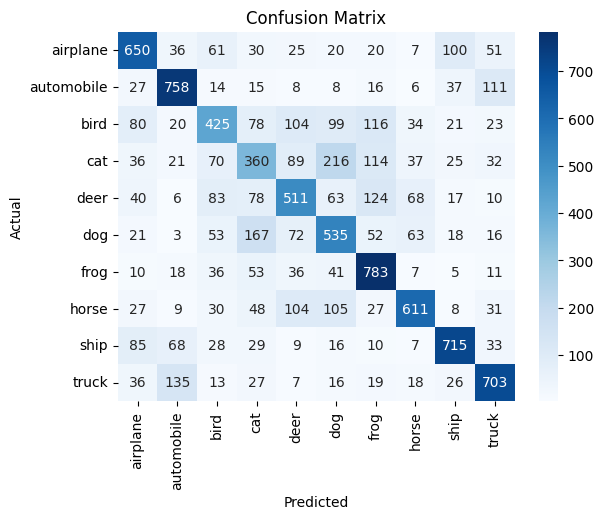

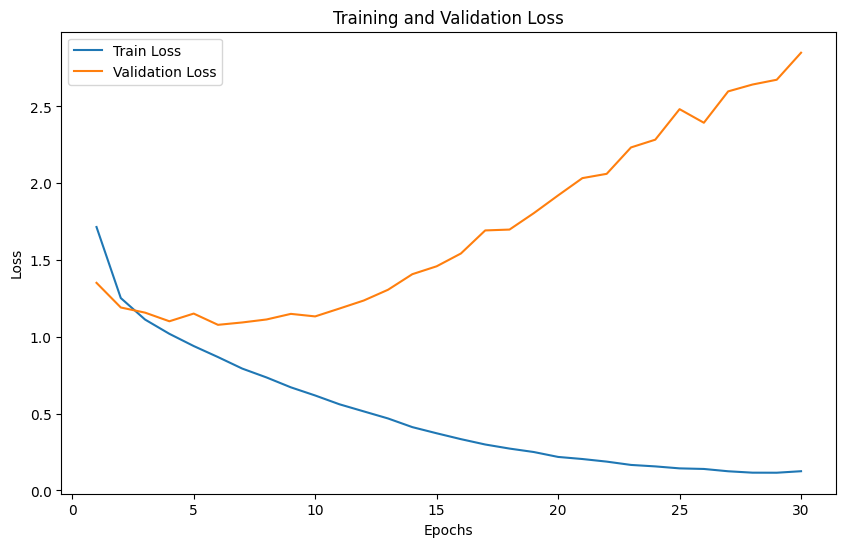

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing regularization: BatchNorm=False, Dropout=0.2
Epoch 1/30, Train Loss: 1.8006, Val Loss: 1.4508, LR: 0.001000
Epoch 2/30, Train Loss: 1.5234, Val Loss: 1.3121, LR: 0.001000
Epoch 3/30, Train Loss: 1.4287, Val Loss: 1.2255, LR: 0.001000
Epoch 4/30, Train Loss: 1.3565, Val Loss: 1.1939, LR: 0.001000
Epoch 5/30, Train Loss: 1.2793, Val Loss: 1.2146, LR: 0.001000
Epoch 6/30, Train Loss: 1.2235, Val Loss: 1.1319, LR: 0.001000
Epoch 7/30, Train Loss: 1.1701, Val Loss: 1.1561, LR: 0.001000
Epoch 8/30, Train Loss: 1.1176, Val Loss: 1.2166, LR: 0.001000
Epoch 9/30, Train Loss: 1.0714, Val Loss: 1.1899, LR: 0.001000
Epoch 10/30, Train Loss: 1.0215, Val Loss: 1.1486, LR: 0.001000
Epoch 11/30, Train Loss: 0.9848, Val Loss: 1.1660, LR: 0.001000
Epoch 12/30, Train Loss: 0.9360, Val Loss: 1.1493, LR: 0.001000
Epoch 13/30, Train Loss: 0.8883, Val Loss: 1.2171, LR: 0.001000
Epoch 14/30, Train Loss: 0.8576, Val Loss: 1.2312, LR: 0.001000
Epoch 15/30, Train Loss: 0.8151, Val Loss: 1.2771, LR: 0.001

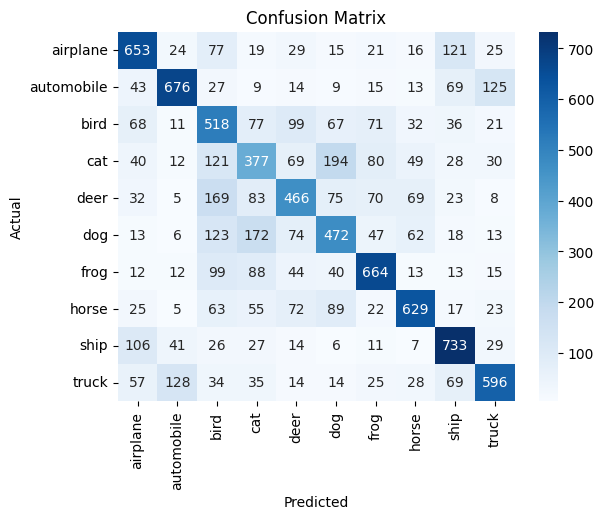

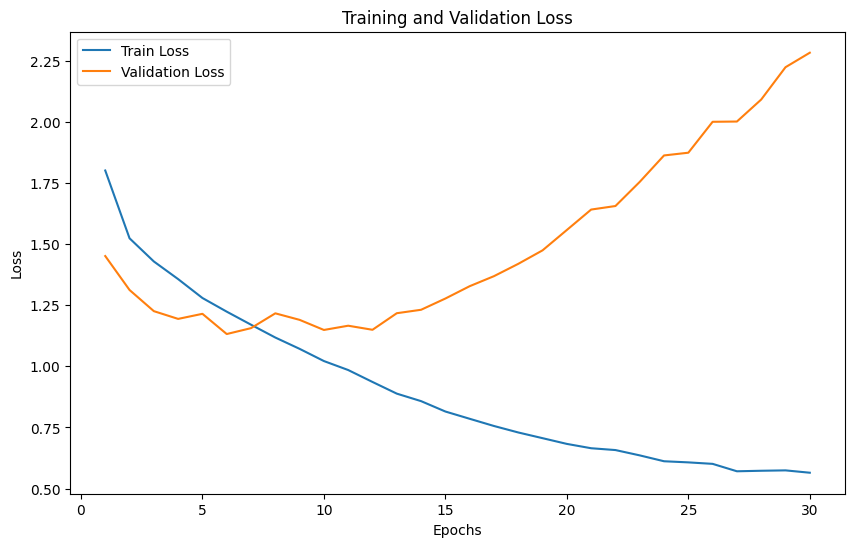

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing regularization: BatchNorm=False, Dropout=0.4
Epoch 1/30, Train Loss: 2.2692, Val Loss: 1.5812, LR: 0.001000
Epoch 2/30, Train Loss: 1.7869, Val Loss: 1.4596, LR: 0.001000
Epoch 3/30, Train Loss: 1.7075, Val Loss: 1.3829, LR: 0.001000
Epoch 4/30, Train Loss: 1.6502, Val Loss: 1.3734, LR: 0.001000
Epoch 5/30, Train Loss: 1.6126, Val Loss: 1.3066, LR: 0.001000
Epoch 6/30, Train Loss: 1.5699, Val Loss: 1.2682, LR: 0.001000
Epoch 7/30, Train Loss: 1.5281, Val Loss: 1.2122, LR: 0.001000
Epoch 8/30, Train Loss: 1.5100, Val Loss: 1.2109, LR: 0.001000
Epoch 9/30, Train Loss: 1.4638, Val Loss: 1.1662, LR: 0.001000
Epoch 10/30, Train Loss: 1.4384, Val Loss: 1.1686, LR: 0.001000
Epoch 11/30, Train Loss: 1.3969, Val Loss: 1.1349, LR: 0.001000
Epoch 12/30, Train Loss: 1.3589, Val Loss: 1.1129, LR: 0.001000
Epoch 13/30, Train Loss: 1.3280, Val Loss: 1.1470, LR: 0.001000
Epoch 14/30, Train Loss: 1.3135, Val Loss: 1.1429, LR: 0.001000
Epoch 15/30, Train Loss: 1.2753, Val Loss: 1.1156, LR: 0.001

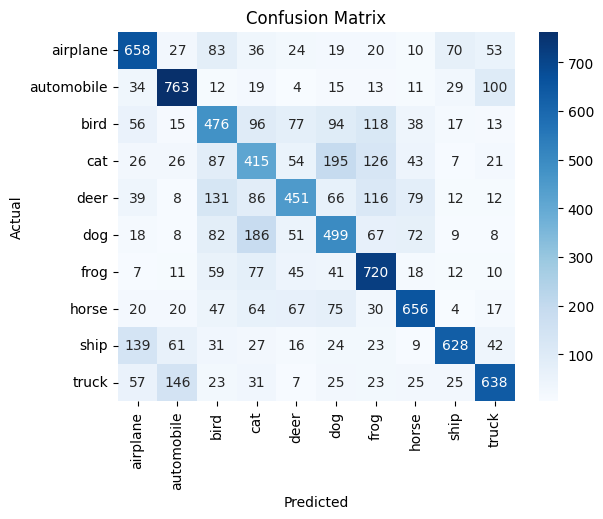

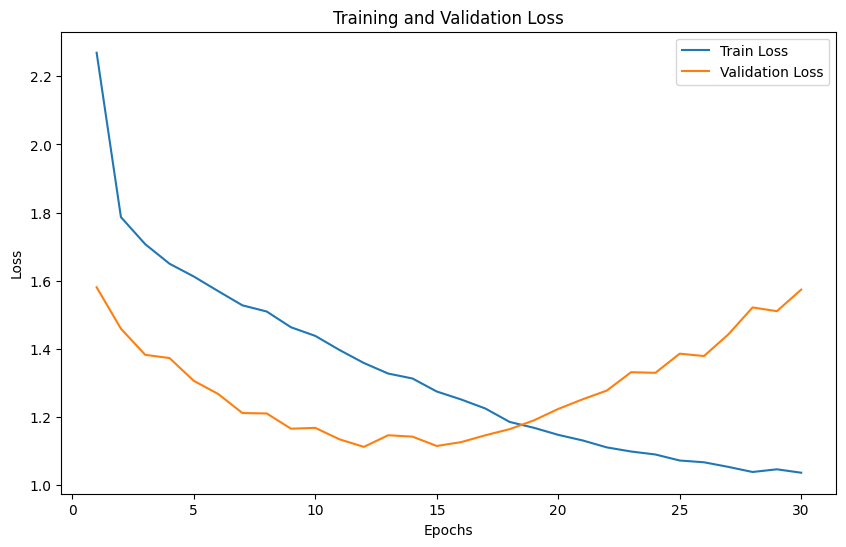

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing regularization: BatchNorm=False, Dropout=0.6
Epoch 1/30, Train Loss: 2.2300, Val Loss: 1.8011, LR: 0.001000
Epoch 2/30, Train Loss: 2.0051, Val Loss: 1.6642, LR: 0.001000
Epoch 3/30, Train Loss: 1.9456, Val Loss: 1.5749, LR: 0.001000
Epoch 4/30, Train Loss: 1.9047, Val Loss: 1.6361, LR: 0.001000
Epoch 5/30, Train Loss: 1.8807, Val Loss: 1.6275, LR: 0.001000
Epoch 6/30, Train Loss: 1.8520, Val Loss: 1.5154, LR: 0.001000
Epoch 7/30, Train Loss: 1.8318, Val Loss: 1.4566, LR: 0.001000
Epoch 8/30, Train Loss: 1.8066, Val Loss: 1.4426, LR: 0.001000
Epoch 9/30, Train Loss: 1.7812, Val Loss: 1.4354, LR: 0.001000
Epoch 10/30, Train Loss: 1.7641, Val Loss: 1.4185, LR: 0.001000
Epoch 11/30, Train Loss: 1.7414, Val Loss: 1.3610, LR: 0.001000
Epoch 12/30, Train Loss: 1.7282, Val Loss: 1.3542, LR: 0.001000
Epoch 13/30, Train Loss: 1.7027, Val Loss: 1.3229, LR: 0.001000
Epoch 14/30, Train Loss: 1.6825, Val Loss: 1.3144, LR: 0.001000
Epoch 15/30, Train Loss: 1.6746, Val Loss: 1.3470, LR: 0.001

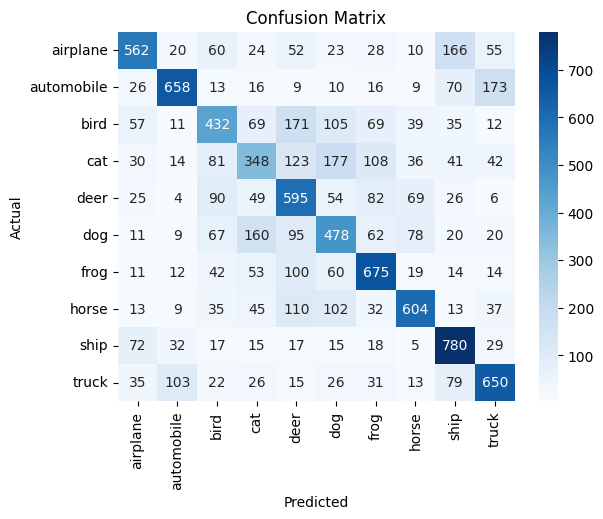

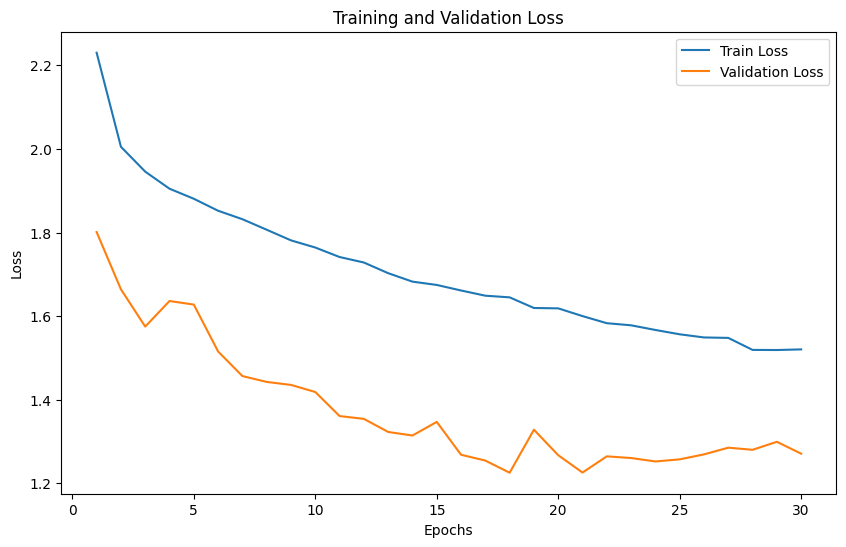

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing regularization: BatchNorm=True, Dropout=None
Epoch 1/30, Train Loss: 2.6508, Val Loss: 1.8993, LR: 0.001000
Epoch 2/30, Train Loss: 1.8026, Val Loss: 1.7153, LR: 0.001000
Epoch 3/30, Train Loss: 1.6539, Val Loss: 1.5981, LR: 0.001000
Epoch 4/30, Train Loss: 1.5132, Val Loss: 1.4375, LR: 0.001000
Epoch 5/30, Train Loss: 1.3981, Val Loss: 1.4628, LR: 0.001000
Epoch 6/30, Train Loss: 1.3227, Val Loss: 1.3551, LR: 0.001000
Epoch 7/30, Train Loss: 1.2646, Val Loss: 1.2994, LR: 0.001000
Epoch 8/30, Train Loss: 1.2022, Val Loss: 1.3234, LR: 0.001000
Epoch 9/30, Train Loss: 1.1602, Val Loss: 1.2684, LR: 0.001000
Epoch 10/30, Train Loss: 1.1307, Val Loss: 1.2199, LR: 0.001000
Epoch 11/30, Train Loss: 1.1046, Val Loss: 1.2366, LR: 0.001000
Epoch 12/30, Train Loss: 1.0809, Val Loss: 1.2275, LR: 0.001000
Epoch 13/30, Train Loss: 1.0649, Val Loss: 1.1352, LR: 0.001000
Epoch 14/30, Train Loss: 1.0432, Val Loss: 1.1245, LR: 0.001000
Epoch 15/30, Train Loss: 1.0253, Val Loss: 1.1493, LR: 0.001

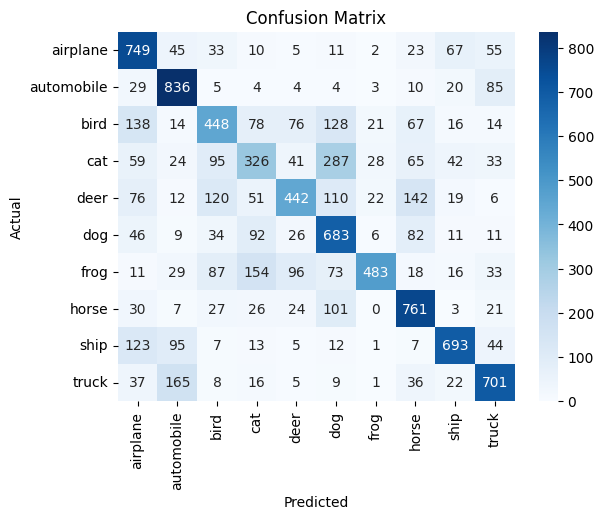

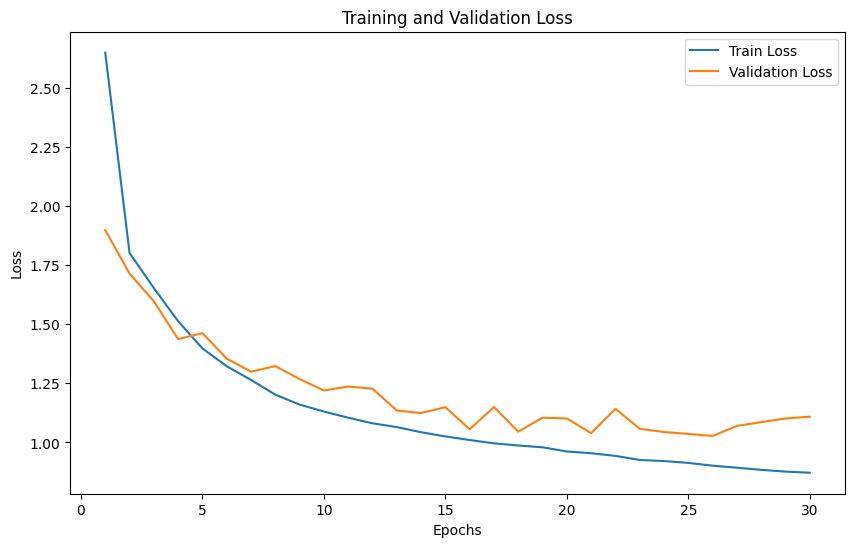

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing regularization: BatchNorm=True, Dropout=0.2
Epoch 1/30, Train Loss: 2.8442, Val Loss: 2.2942, LR: 0.001000
Epoch 2/30, Train Loss: 2.2948, Val Loss: 2.2597, LR: 0.001000
Epoch 3/30, Train Loss: 2.2880, Val Loss: 2.2708, LR: 0.001000
Epoch 4/30, Train Loss: 2.2511, Val Loss: 2.1508, LR: 0.001000
Epoch 5/30, Train Loss: 2.1121, Val Loss: 1.9852, LR: 0.001000
Epoch 6/30, Train Loss: 2.0565, Val Loss: 2.0241, LR: 0.001000
Epoch 7/30, Train Loss: 2.0405, Val Loss: 1.9424, LR: 0.001000
Epoch 8/30, Train Loss: 2.0228, Val Loss: 1.9559, LR: 0.001000
Epoch 9/30, Train Loss: 2.0053, Val Loss: 1.9108, LR: 0.001000
Epoch 10/30, Train Loss: 1.9859, Val Loss: 1.9088, LR: 0.001000
Epoch 11/30, Train Loss: 1.9664, Val Loss: 1.9400, LR: 0.001000
Epoch 12/30, Train Loss: 1.9489, Val Loss: 1.9087, LR: 0.001000
Epoch 13/30, Train Loss: 1.9398, Val Loss: 1.8738, LR: 0.001000
Epoch 14/30, Train Loss: 1.9216, Val Loss: 1.8299, LR: 0.001000
Epoch 15/30, Train Loss: 1.8803, Val Loss: 1.7696, LR: 0.0010

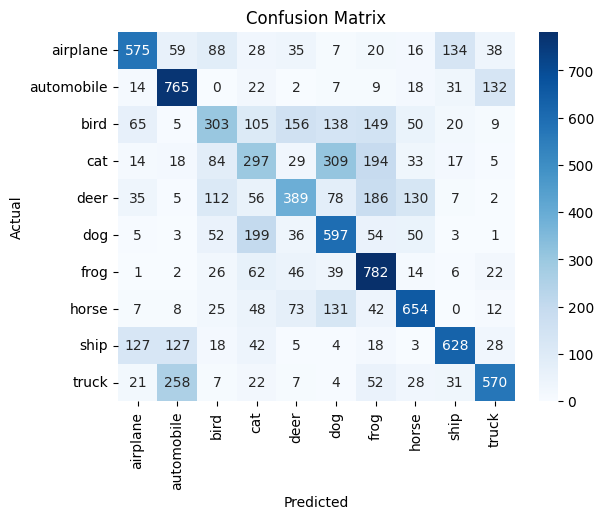

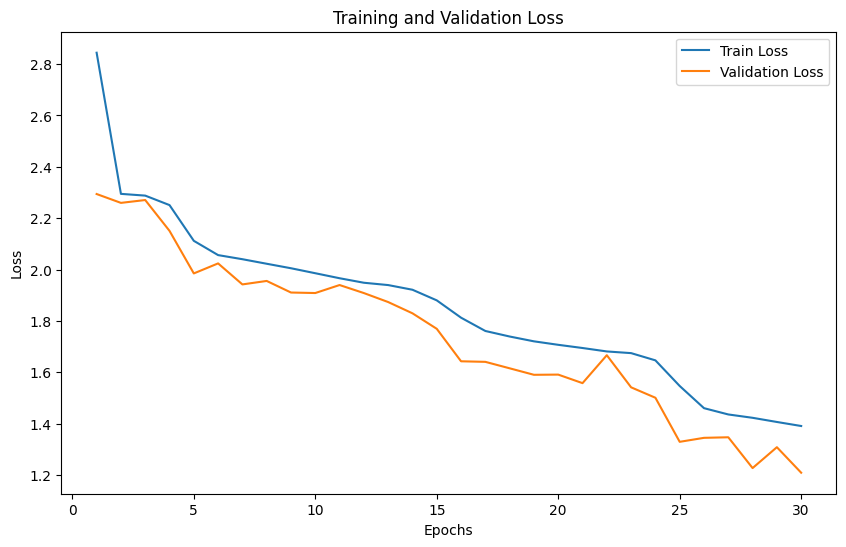

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing regularization: BatchNorm=True, Dropout=0.4
Epoch 1/30, Train Loss: 3.0025, Val Loss: 2.2886, LR: 0.001000
Epoch 2/30, Train Loss: 2.2782, Val Loss: 2.2302, LR: 0.001000
Epoch 3/30, Train Loss: 2.1975, Val Loss: 2.0825, LR: 0.001000
Epoch 4/30, Train Loss: 2.1429, Val Loss: 2.0363, LR: 0.001000
Epoch 5/30, Train Loss: 2.1281, Val Loss: 1.9952, LR: 0.001000
Epoch 6/30, Train Loss: 2.1104, Val Loss: 1.9558, LR: 0.001000
Epoch 7/30, Train Loss: 2.0740, Val Loss: 2.0687, LR: 0.001000
Epoch 8/30, Train Loss: 2.0342, Val Loss: 1.8839, LR: 0.001000
Epoch 9/30, Train Loss: 1.9803, Val Loss: 1.7523, LR: 0.001000
Epoch 10/30, Train Loss: 1.9299, Val Loss: 1.6825, LR: 0.001000
Epoch 11/30, Train Loss: 1.9203, Val Loss: 1.7018, LR: 0.001000
Epoch 12/30, Train Loss: 1.8918, Val Loss: 1.7538, LR: 0.001000
Epoch 13/30, Train Loss: 1.8777, Val Loss: 1.7178, LR: 0.001000
Epoch 14/30, Train Loss: 1.8464, Val Loss: 1.6729, LR: 0.001000
Epoch 15/30, Train Loss: 1.8079, Val Loss: 1.5520, LR: 0.0010

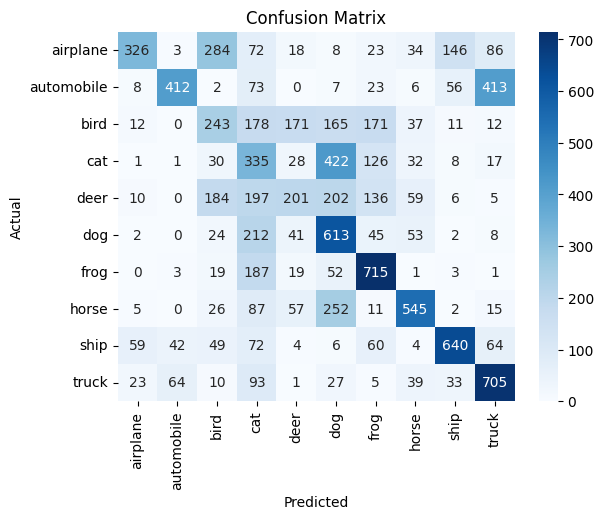

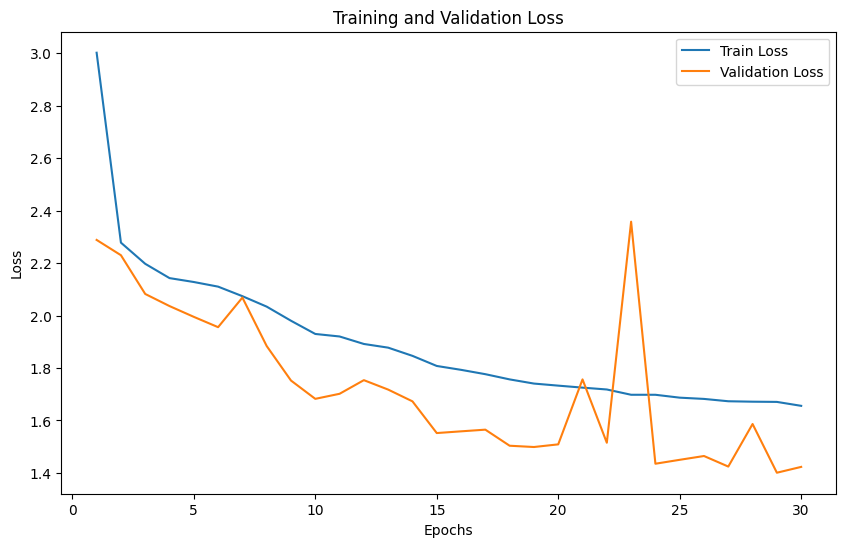

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing regularization: BatchNorm=True, Dropout=0.6
Epoch 1/30, Train Loss: 3.2466, Val Loss: 2.3028, LR: 0.001000
Epoch 2/30, Train Loss: 2.3037, Val Loss: 2.3026, LR: 0.001000
Epoch 3/30, Train Loss: 2.3036, Val Loss: 2.3026, LR: 0.001000
Epoch 4/30, Train Loss: 2.3034, Val Loss: 2.3024, LR: 0.001000
Epoch 5/30, Train Loss: 2.3030, Val Loss: 2.3027, LR: 0.001000
Epoch 6/30, Train Loss: 2.3028, Val Loss: 2.3027, LR: 0.001000
Epoch 7/30, Train Loss: 2.3044, Val Loss: 2.3030, LR: 0.001000
Epoch 8/30, Train Loss: 2.3028, Val Loss: 2.3027, LR: 0.001000
Epoch 9/30, Train Loss: 2.3027, Val Loss: 2.3028, LR: 0.001000
Epoch 10/30, Train Loss: 2.3028, Val Loss: 2.3027, LR: 0.001000
Epoch 11/30, Train Loss: 2.3027, Val Loss: 2.3026, LR: 0.001000
Epoch 12/30, Train Loss: 2.3027, Val Loss: 2.3027, LR: 0.001000
Epoch 13/30, Train Loss: 2.3027, Val Loss: 2.3027, LR: 0.001000
Epoch 14/30, Train Loss: 2.3027, Val Loss: 2.3028, LR: 0.001000
Epoch 15/30, Train Loss: 2.3027, Val Loss: 2.3028, LR: 0.0010

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report:
               precision    recall  f1-score   support

    airplane       0.00      0.00      0.00      1000
  automobile       0.00      0.00      0.00      1000
        bird       0.00      0.00      0.00      1000
         cat       0.00      0.00      0.00      1000
        deer       0.10      1.00      0.18      1000
         dog       0.00      0.00      0.00      1000
        frog       0.00      0.00      0.00      1000
       horse       0.00      0.00      0.00      1000
        ship       0.00      0.00      0.00      1000
       truck       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



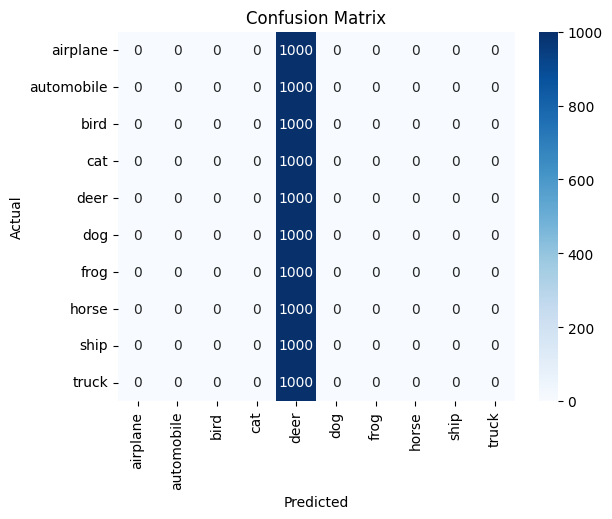

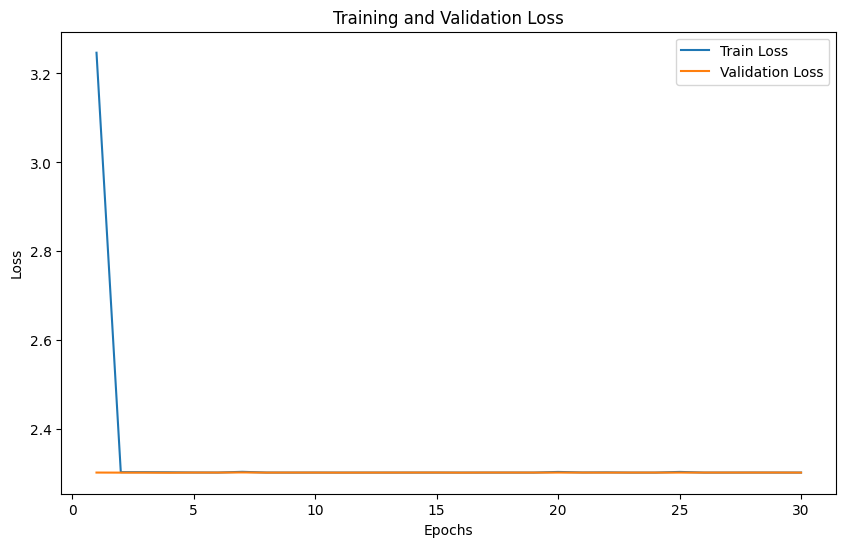

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Experiment Results:
             Regularization Type  Accuracy (%)  Train Loss  Val Loss  \
0  BatchNorm=False, Dropout=None         60.51    0.125062  2.849994   
1   BatchNorm=False, Dropout=0.2         57.84    0.564855  2.282253   
2   BatchNorm=False, Dropout=0.4         59.04    1.037036  1.574138   
3   BatchNorm=False, Dropout=0.6         57.82    1.520415  1.270975   
4   BatchNorm=True, Dropout=None         61.22    0.871562  1.108944   
5    BatchNorm=True, Dropout=0.2         55.60    1.391303  1.209471   
6    BatchNorm=True, Dropout=0.4         47.35    1.655822  1.422978   
7    BatchNorm=True, Dropout=0.6         10.00    2.302731  2.302669   

     Time (s)  Memory (MB)  
0  323.898752    79.256576  
1  322.798218    90.319360  
2  333.159279    85.640704  
3  322.158338    81.908224  
4  323.201379    82.148864  
5  328.161572    83.485184  
6  325.240513    83.484160  
7  325.497866    85.769728  


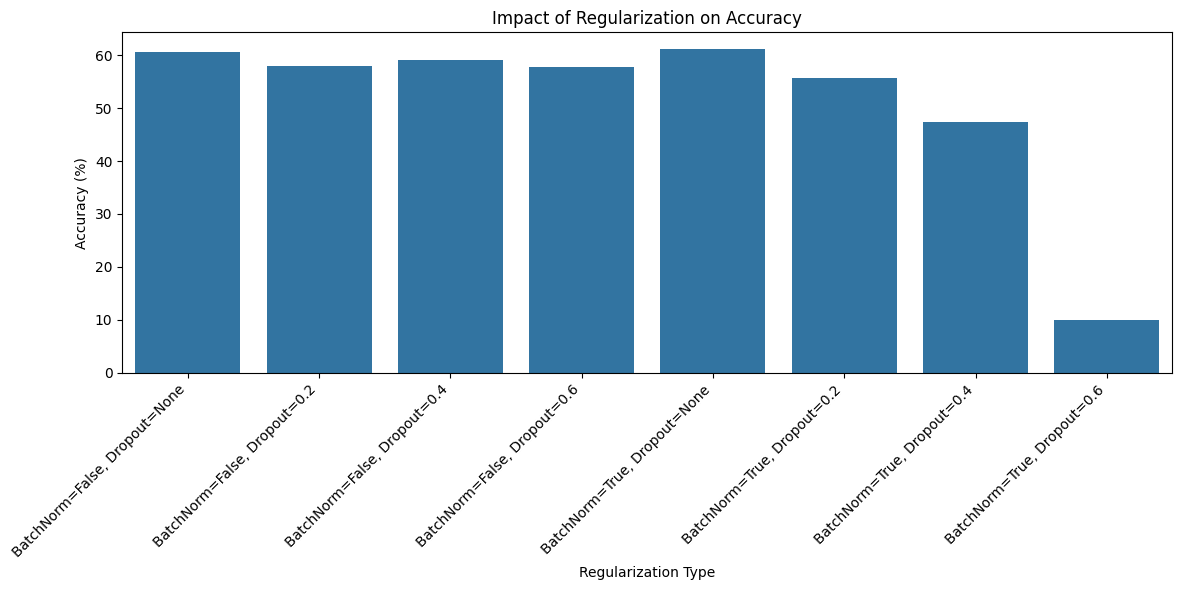

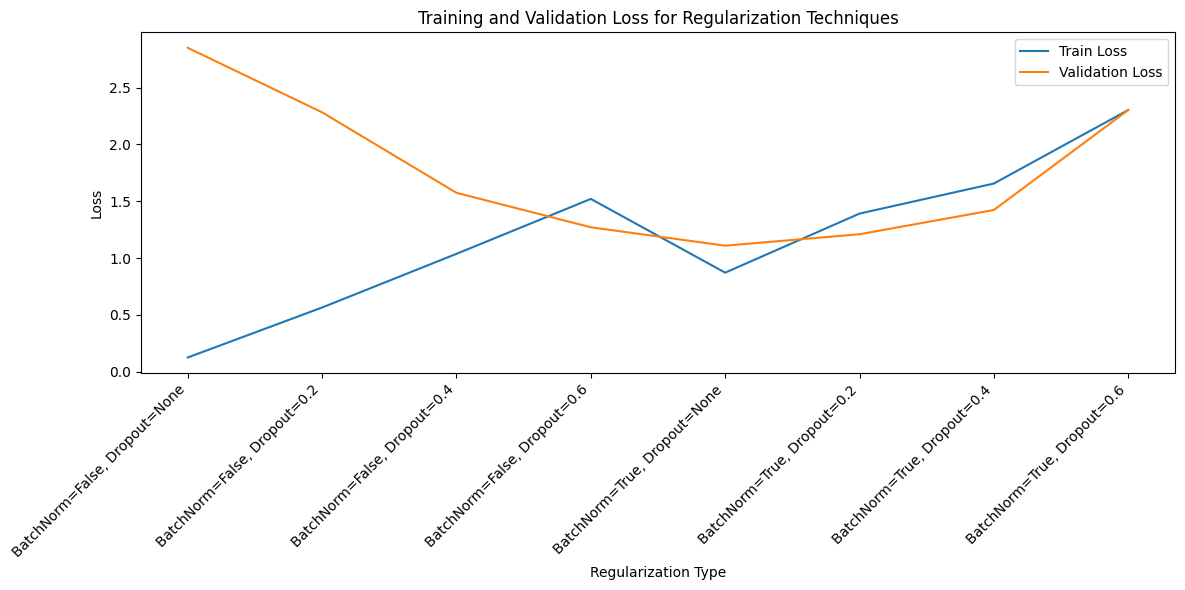

In [ ]:
dropout_rates = [0.2, 0.4, 0.6]  # Different dropout rates to test
use_batch_norm = [False, True]   # Baseline and with BatchNorm
epochs = 30
lr = 0.001

results = []

for is_batch_norm in use_batch_norm:
    for dropout_rate in ([1.0] + dropout_rates):  # Include baseline without dropout
        reg_type = f"BatchNorm={is_batch_norm}, Dropout={'None' if dropout_rate==1.0 else dropout_rate}"
        print(f"Testing regularization: {reg_type}")

        model = Model(k1=3, k2=3, is_batch=is_batch_norm, is_dropout=(dropout_rate!=1.0), dp=dropout_rate).to(device)

        start_time = time.time()
        train_losses, val_losses = train(model, trainloader, valloader, lr=lr, epochs=epochs)
        end_time = time.time()

        print(f"Evaluating model for {reg_type}...")
        evaluate_and_plot(model, testloader, train_losses, val_losses)

        memory_usage = torch.cuda.max_memory_allocated(device) / 1e6 if torch.cuda.is_available() else "N/A"

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total

        results.append({
            "Regularization Type": reg_type,
            "Accuracy (%)": accuracy,
            "Train Loss": train_losses[-1],
            "Val Loss": val_losses[-1],
            "Time (s)": end_time - start_time,
            "Memory (MB)": memory_usage
        })

        # Reset GPU memory if CUDA is available
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats(device)

results_df = pd.DataFrame(results)

print("\nExperiment Results:")
print(results_df)

plt.figure(figsize=(12, 6))
sns.barplot(x="Regularization Type", y="Accuracy (%)", data=results_df)
plt.xticks(rotation=45, ha="right")
plt.title("Impact of Regularization on Accuracy")
plt.ylabel("Accuracy (%)")
plt.xlabel("Regularization Type")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x="Regularization Type", y="Train Loss", label="Train Loss")
sns.lineplot(data=results_df, x="Regularization Type", y="Val Loss", label="Validation Loss")
plt.xticks(rotation=45, ha="right")
plt.title("Training and Validation Loss for Regularization Techniques")
plt.ylabel("Loss")
plt.xlabel("Regularization Type")
plt.tight_layout()
plt.legend()
plt.show()


#### 1.2.1 Results and conclusion
##### **Impact of Dropout and Batch Normalization on Model Performance**

| **Regularization Type**          | **Accuracy (%)** | **Train Loss** | **Val Loss** | **Time (s)** | **Memory (MB)** |
|----------------------------------|------------------|----------------|--------------|--------------|-----------------|
| BatchNorm=False, Dropout=None    | 60.51            | 0.1251         | 2.8500       | 323.90       | 79.26           |
| BatchNorm=False, Dropout=0.2     | 57.84            | 0.5649         | 2.2823       | 322.80       | 90.32           |
| BatchNorm=False, Dropout=0.4     | 59.04            | 1.0370         | 1.5741       | 333.16       | 85.64           |
| BatchNorm=False, Dropout=0.6     | 57.82            | 1.5204         | 1.2710       | 322.16       | 81.91           |
| BatchNorm=True, Dropout=None     | 61.22            | 0.8716         | 1.1089       | 323.20       | 82.15           |
| BatchNorm=True, Dropout=0.2      | 55.60            | 1.3913         | 1.2095       | 328.16       | 83.49           |
| BatchNorm=True, Dropout=0.4      | 47.35            | 1.6558         | 1.4230       | 325.24       | 83.48           |
| BatchNorm=True, Dropout=0.6      | 10.00            | 2.3027         | 2.3027       | 325.50       | 85.77           |

---

##### **Conclusions**

1. **Without Regularization**:
   - The model achieved **moderate accuracy (60.51%)** with the lowest training loss (0.1251) but the highest validation loss (2.8500), indicating overfitting.

2. **Dropout**:
   - Applying **Dropout** improves validation loss at moderate rates (e.g., 0.4 achieves a validation loss of 1.5741), but excessive rates (0.6) significantly degrade accuracy.
   - Dropout reduces overfitting by introducing randomness during training but may slow convergence and lead to instability when over-applied.

3. **Batch Normalization**:
   - Batch Normalization improved both **accuracy (61.22%)** and validation loss (1.1089) when used without Dropout, indicating faster convergence and better generalization.
   - Combining BatchNorm with high Dropout rates (e.g., 0.6) resulted in poor performance (10.00% accuracy), likely due to over-regularization and unstable optimization.

4. **Memory Usage**:
   - **Dropout** increased memory usage slightly due to additional computations for stochastic masking.
   - Models with **Batch Normalization** also consumed more memory but were more efficient than Dropout in improving generalization.


##### 1.3 batch size

In [ ]:
# Experiment configurations
batch_sizes = [1, 32, 64, 128]  # Different batch sizes to test
epochs = 30
lr = 0.001
NUM_WORKERS = 2

# Data preprocessing
transform = transforms.ToTensor()
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Splitting train and validation datasets
VALIDATION_SPLIT = 0.1
train_size = int((1 - VALIDATION_SPLIT) * len(trainset))
val_size = len(trainset) - train_size
train_subset, val_subset = random_split(trainset, [train_size, val_size])

# Record results
results = []

for batch_size in batch_sizes:
    print(f"Testing with Batch Size = {batch_size}")

    trainloader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
    valloader = DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)

    model = Model(k1=3, k2=3).to(device)

    # Train the model and record memory usage
    start_time = time.time()
    train_losses, val_losses = train(model, trainloader, valloader, lr=lr, epochs=epochs)
    end_time = time.time()

    # Evaluate and plot results
    print(f"Evaluating model with Batch Size = {batch_size}...")
    evaluate_and_plot(model, testloader, train_losses, val_losses)

    # Measure GPU memory usage if CUDA is available
    memory_usage = torch.cuda.max_memory_allocated(device) / 1e6 if torch.cuda.is_available() else "N/A"

    # Evaluate test accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total

    # Record results
    results.append({
        "Batch Size": batch_size,
        "Accuracy (%)": accuracy,
        "Train Loss": train_losses[-1],
        "Val Loss": val_losses[-1],
        "Time (s)": end_time - start_time,
        "Memory (MB)": memory_usage
    })

    # Reset GPU memory if CUDA is available
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results in tabular format
print("\nExperiment Results:")
print(results_df)

# Plot accuracy comparison
plt.figure(figsize=(12, 6))
sns.barplot(x="Batch Size", y="Accuracy (%)", data=results_df)
plt.title("Impact of Batch Size on Accuracy")
plt.ylabel("Accuracy (%)")
plt.xlabel("Batch Size")
plt.tight_layout()
plt.show()

# Plot training and validation loss for comparison
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x="Batch Size", y="Train Loss", label="Train Loss")
sns.lineplot(data=results_df, x="Batch Size", y="Val Loss", label="Validation Loss")
plt.title("Training and Validation Loss vs Batch Size")
plt.ylabel("Loss")
plt.xlabel("Batch Size")
plt.tight_layout()
plt.legend()
plt.show()


Files already downloaded and verified
Files already downloaded and verified
Testing with Batch Size = 1
Epoch 1/20, Train Loss: 1.6307, Val Loss: 1.6554, LR: 0.001000
Epoch 2/20, Train Loss: 1.3868, Val Loss: 1.4420, LR: 0.001000
Epoch 3/20, Train Loss: 1.2706, Val Loss: 1.3537, LR: 0.001000
Epoch 4/20, Train Loss: 1.1820, Val Loss: 1.3460, LR: 0.001000
Epoch 5/20, Train Loss: 1.1020, Val Loss: 1.3972, LR: 0.001000
Epoch 6/20, Train Loss: 1.0338, Val Loss: 1.4675, LR: 0.001000
Epoch 7/20, Train Loss: 0.9799, Val Loss: 1.6090, LR: 0.001000
Epoch 8/20, Train Loss: 0.9160, Val Loss: 1.5061, LR: 0.001000
Epoch 9/20, Train Loss: 0.8593, Val Loss: 1.6566, LR: 0.001000
Epoch 10/20, Train Loss: 0.8156, Val Loss: 1.8122, LR: 0.001000
Epoch 11/20, Train Loss: 0.7731, Val Loss: 1.7399, LR: 0.001000
Epoch 12/20, Train Loss: 0.7314, Val Loss: 2.0366, LR: 0.001000
Epoch 13/20, Train Loss: 0.6927, Val Loss: 2.0400, LR: 0.001000
Epoch 14/20, Train Loss: 0.6565, Val Loss: 2.0644, LR: 0.001000
Epoch 15/20, Train Loss: 0.6366, Val Loss: 2.3118, LR: 0.001000
Epoch 16/20, Train Loss: 0.6014, Val Loss: 2.5400, LR: 0.001000
Epoch 17/20, Train Loss: 0.5863, Val Loss: 3.5676, LR: 0.001000
Epoch 18/20, Train Loss: 0.5569, Val Loss: 2.6498, LR: 0.001000
Epoch 19/20, Train Loss: 0.5330, Val Loss: 2.9278, LR: 0.001000
Epoch 20/20, Train Loss: 0.5207, Val Loss: 3.3422, LR: 0.001000
Evaluating model with Batch Size = 1...

Classification Report:
               precision    recall  f1-score   support

    airplane       0.59      0.47      0.52      1000
  automobile       0.70      0.61      0.65      1000
        bird       0.41      0.32      0.36      1000
         cat       0.31      0.39      0.35      1000
        deer       0.40      0.41      0.41      1000
         dog       0.41      0.38      0.39      1000
        frog       0.57      0.58      0.57      1000
       horse       0.54      0.60      0.57      1000
        ship       0.60      0.64      0.62      1000
       truck       0.55      0.65      0.60      1000

    accuracy                           0.50     10000
   macro avg       0.51      0.50      0.50     10000
weighted avg       0.51      0.50      0.50     10000

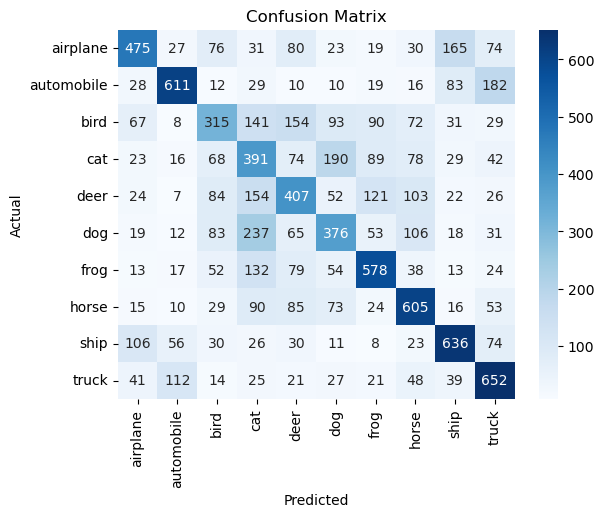

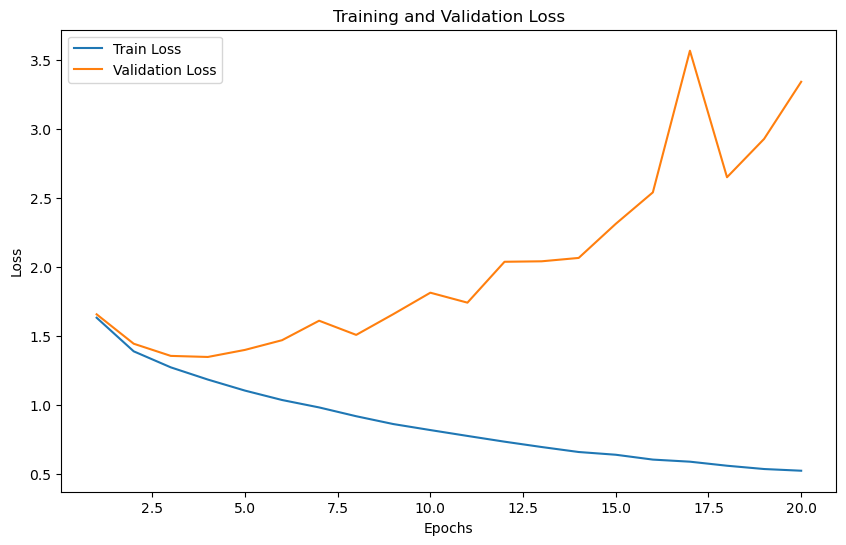

Testing with Batch Size = 32
Epoch 1/20, Train Loss: 1.7086, Val Loss: 1.3960, LR: 0.001000
Epoch 2/20, Train Loss: 1.3110, Val Loss: 1.2716, LR: 0.001000
Epoch 3/20, Train Loss: 1.1832, Val Loss: 1.2644, LR: 0.001000
Epoch 4/20, Train Loss: 1.0808, Val Loss: 1.2274, LR: 0.001000
Epoch 5/20, Train Loss: 0.9912, Val Loss: 1.2024, LR: 0.001000
Epoch 6/20, Train Loss: 0.9088, Val Loss: 1.2137, LR: 0.001000
Epoch 7/20, Train Loss: 0.8303, Val Loss: 1.1955, LR: 0.001000
Epoch 8/20, Train Loss: 0.7526, Val Loss: 1.2795, LR: 0.001000
Epoch 9/20, Train Loss: 0.6780, Val Loss: 1.3377, LR: 0.001000
Epoch 10/20, Train Loss: 0.6074, Val Loss: 1.4122, LR: 0.001000
Epoch 11/20, Train Loss: 0.5479, Val Loss: 1.4505, LR: 0.001000
Epoch 12/20, Train Loss: 0.4857, Val Loss: 1.5754, LR: 0.001000
Epoch 13/20, Train Loss: 0.4289, Val Loss: 1.6023, LR: 0.001000
Epoch 14/20, Train Loss: 0.3835, Val Loss: 1.7764, LR: 0.001000
Epoch 15/20, Train Loss: 0.3370, Val Loss: 1.8949, LR: 0.001000
Epoch 16/20, Train Loss: 0.3006, Val Loss: 2.0348, LR: 0.001000
Epoch 17/20, Train Loss: 0.2692, Val Loss: 2.1497, LR: 0.001000
Epoch 18/20, Train Loss: 0.2429, Val Loss: 2.2910, LR: 0.001000
Epoch 19/20, Train Loss: 0.2137, Val Loss: 2.4521, LR: 0.001000
Epoch 20/20, Train Loss: 0.1984, Val Loss: 2.4773, LR: 0.001000
Evaluating model with Batch Size = 32...

Classification Report:
               precision    recall  f1-score   support

    airplane       0.61      0.66      0.63      1000
  automobile       0.73      0.63      0.68      1000
        bird       0.45      0.43      0.44      1000
         cat       0.40      0.36      0.38      1000
        deer       0.48      0.48      0.48      1000
         dog       0.48      0.47      0.48      1000
        frog       0.56      0.70      0.62      1000
       horse       0.61      0.67      0.64      1000
        ship       0.68      0.68      0.68      1000
       truck       0.67      0.58      0.62      1000

    accuracy                           0.57     10000
   macro avg       0.57      0.57      0.57     10000
weighted avg       0.57      0.57      0.57     10000

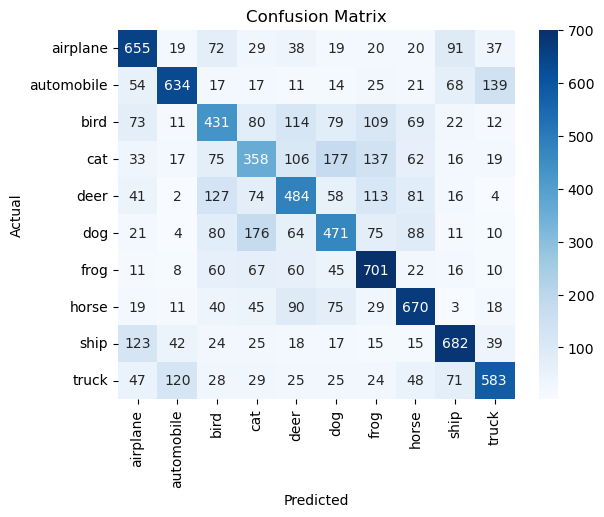

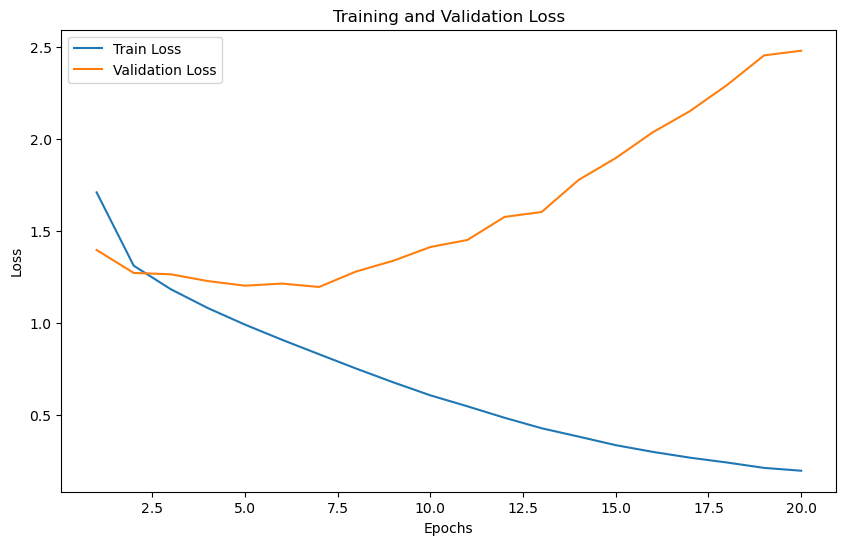

Testing with Batch Size = 64
Epoch 1/20, Train Loss: 1.6550, Val Loss: 1.3046, LR: 0.001000
Epoch 2/20, Train Loss: 1.2256, Val Loss: 1.3254, LR: 0.001000
Epoch 3/20, Train Loss: 1.0852, Val Loss: 1.1077, LR: 0.001000
Epoch 4/20, Train Loss: 0.9870, Val Loss: 1.0709, LR: 0.001000
Epoch 5/20, Train Loss: 0.9078, Val Loss: 1.0752, LR: 0.001000
Epoch 6/20, Train Loss: 0.8329, Val Loss: 1.1417, LR: 0.001000
Epoch 7/20, Train Loss: 0.7696, Val Loss: 1.0801, LR: 0.001000
Epoch 8/20, Train Loss: 0.6975, Val Loss: 1.0914, LR: 0.001000
Epoch 9/20, Train Loss: 0.6409, Val Loss: 1.1078, LR: 0.001000
Epoch 10/20, Train Loss: 0.5892, Val Loss: 1.1482, LR: 0.001000
Epoch 11/20, Train Loss: 0.5285, Val Loss: 1.2438, LR: 0.001000
Epoch 12/20, Train Loss: 0.4759, Val Loss: 1.2544, LR: 0.001000
Epoch 13/20, Train Loss: 0.4313, Val Loss: 1.2958, LR: 0.001000
Epoch 14/20, Train Loss: 0.3760, Val Loss: 1.3202, LR: 0.001000
Epoch 15/20, Train Loss: 0.3394, Val Loss: 1.4587, LR: 0.001000
Epoch 16/20, Train Loss: 0.2963, Val Loss: 1.5237, LR: 0.001000
Epoch 17/20, Train Loss: 0.2674, Val Loss: 1.5987, LR: 0.001000
Epoch 18/20, Train Loss: 0.2404, Val Loss: 1.6799, LR: 0.001000
Epoch 19/20, Train Loss: 0.2160, Val Loss: 1.7421, LR: 0.001000
Epoch 20/20, Train Loss: 0.1877, Val Loss: 1.8318, LR: 0.001000
Evaluating model with Batch Size = 64...

Classification Report:
               precision    recall  f1-score   support

    airplane       0.66      0.65      0.66      1000
  automobile       0.77      0.72      0.75      1000
        bird       0.52      0.51      0.52      1000
         cat       0.44      0.40      0.42      1000
        deer       0.63      0.47      0.54      1000
         dog       0.49      0.59      0.53      1000
        frog       0.66      0.75      0.70      1000
       horse       0.71      0.68      0.69      1000
        ship       0.71      0.77      0.74      1000
       truck       0.70      0.72      0.71      1000

    accuracy                           0.63     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.63      0.63      0.63     10000

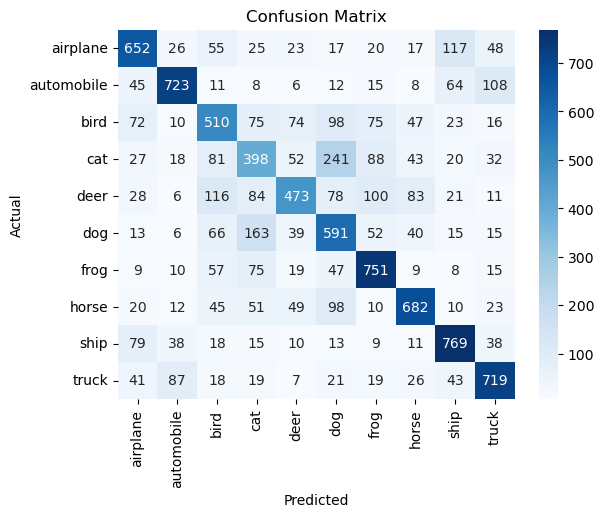

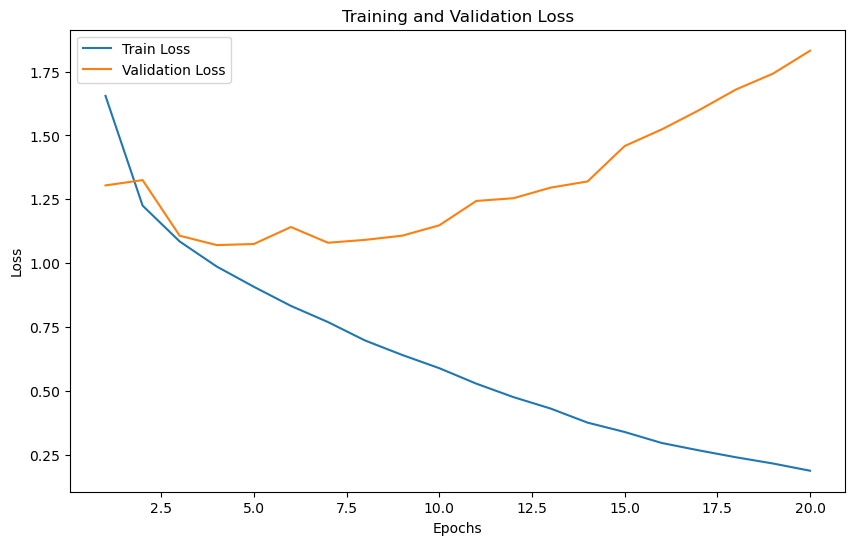

Testing with Batch Size = 128
Epoch 1/20, Train Loss: 1.7016, Val Loss: 1.4421, LR: 0.001000
Epoch 2/20, Train Loss: 1.3460, Val Loss: 1.3501, LR: 0.001000
Epoch 3/20, Train Loss: 1.2347, Val Loss: 1.2584, LR: 0.001000
Epoch 4/20, Train Loss: 1.1512, Val Loss: 1.1959, LR: 0.001000
Epoch 5/20, Train Loss: 1.0767, Val Loss: 1.1758, LR: 0.001000
Epoch 6/20, Train Loss: 1.0135, Val Loss: 1.1457, LR: 0.001000
Epoch 7/20, Train Loss: 0.9401, Val Loss: 1.1057, LR: 0.001000
Epoch 8/20, Train Loss: 0.8779, Val Loss: 1.1093, LR: 0.001000
Epoch 9/20, Train Loss: 0.8185, Val Loss: 1.1249, LR: 0.001000
Epoch 10/20, Train Loss: 0.7680, Val Loss: 1.0754, LR: 0.001000
Epoch 11/20, Train Loss: 0.7174, Val Loss: 1.1031, LR: 0.001000
Epoch 12/20, Train Loss: 0.6743, Val Loss: 1.1303, LR: 0.001000
Epoch 13/20, Train Loss: 0.6266, Val Loss: 1.1409, LR: 0.001000
Epoch 14/20, Train Loss: 0.5788, Val Loss: 1.2043, LR: 0.001000
Epoch 15/20, Train Loss: 0.5471, Val Loss: 1.1687, LR: 0.001000
Epoch 16/20, Train Loss: 0.5020, Val Loss: 1.2293, LR: 0.001000
Epoch 17/20, Train Loss: 0.4698, Val Loss: 1.2466, LR: 0.001000
Epoch 18/20, Train Loss: 0.4302, Val Loss: 1.3039, LR: 0.001000
Epoch 19/20, Train Loss: 0.3976, Val Loss: 1.3973, LR: 0.001000
Epoch 20/20, Train Loss: 0.3622, Val Loss: 1.4400, LR: 0.001000
Evaluating model with Batch Size = 128...

Classification Report:
               precision    recall  f1-score   support

    airplane       0.63      0.73      0.67      1000
  automobile       0.70      0.75      0.73      1000
        bird       0.55      0.44      0.49      1000
         cat       0.42      0.49      0.45      1000
        deer       0.56      0.57      0.57      1000
         dog       0.55      0.51      0.53      1000
        frog       0.73      0.69      0.71      1000
       horse       0.72      0.67      0.69      1000
        ship       0.67      0.79      0.73      1000
       truck       0.74      0.61      0.67      1000

    accuracy                           0.62     10000
   macro avg       0.63      0.62      0.62     10000
weighted avg       0.63      0.62      0.62     10000

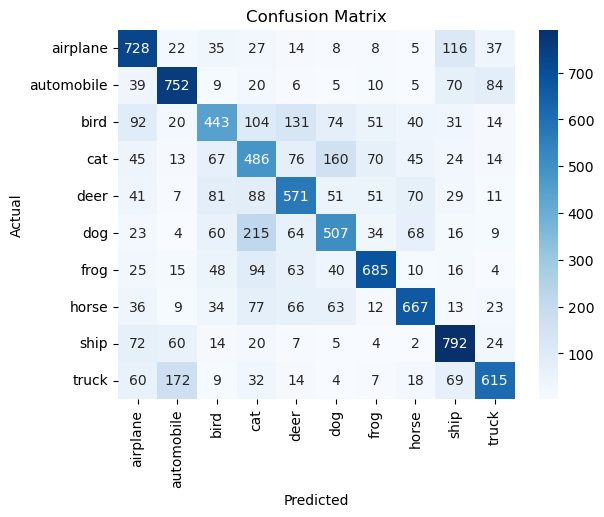
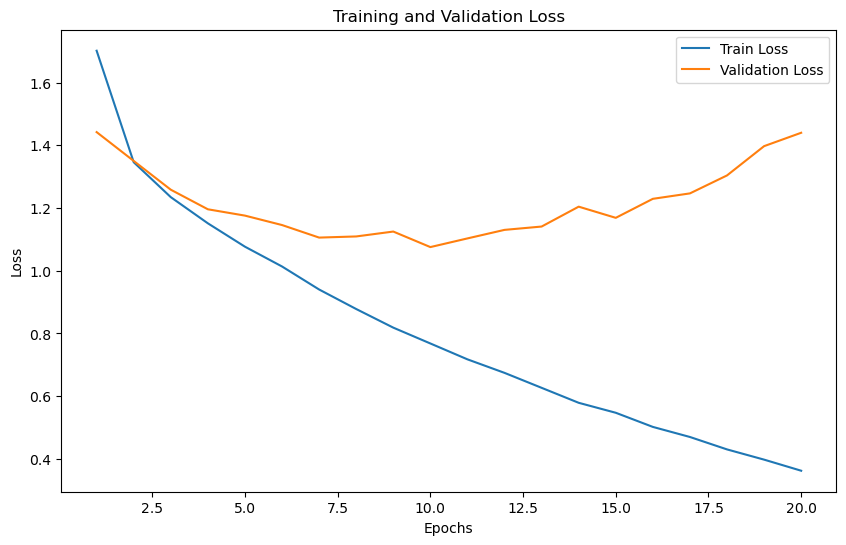

Experiment Results:
   Batch Size  Accuracy (%)  Train Loss  Val Loss     Time (s) Memory (MB)
0           1         50.46    0.520695  3.342244  5483.707953         N/A
1          32         56.69    0.198389  2.477331  3421.536336         N/A
2          64         62.68    0.187716  1.831849  3369.552907         N/A
3         128         62.46    0.362233  1.439988  3327.556498         N/A
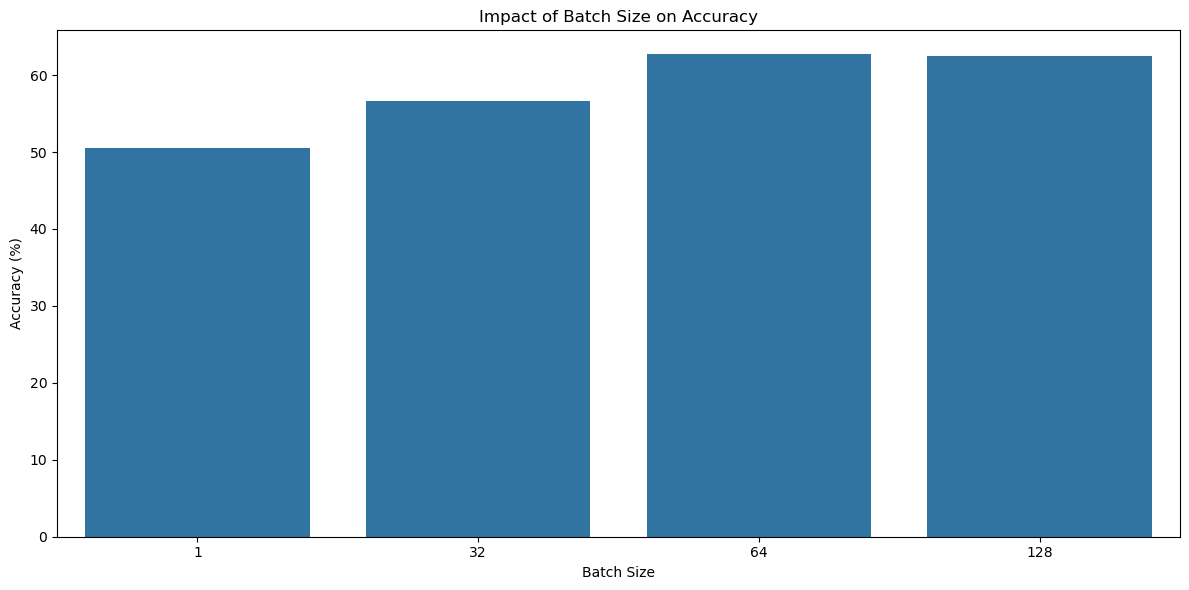

#### 1.3.1 Results and conclusion
### **Impact of Batch Size on Model Performance**

| **Batch Size** | **Accuracy (%)** | **Train Loss** | **Val Loss** | **Time (s)**  | **Memory (MB)** |
|----------------|------------------|----------------|--------------|---------------|-----------------|
| 1              | 50.46           | 0.5207         | 3.3422       | 5483.71       | N/A             |
| 32             | 56.69           | 0.1984         | 2.4773       | 3421.54       | N/A             |
| 64             | **62.68**       | **0.1877**     | 1.8318       | 3369.55       | N/A             |
| 128            | 62.46           | 0.3622         | **1.4400**   | **3327.56**   | N/A             |

---

### **Conclusions**

1. **Small Batch Size (Batch Size = 1)**:
   - Achieved the lowest accuracy (**50.46%**) and highest validation loss (**3.3422**), indicating poor generalization and slow convergence.
   - Training time was the highest (**5483.71 seconds**) due to frequent weight updates, making this approach computationally expensive.

2. **Moderate Batch Sizes (Batch Sizes = 32, 64)**:
   - Batch size **64** achieved the highest accuracy (**62.68%**) with the lowest training loss (**0.1877**) and reasonable validation loss (**1.8318**).
   - Batch size **32** had slightly lower accuracy (**56.69%**) but showed improved convergence compared to batch size **1**.

3. **Large Batch Size (Batch Size = 128)**:
   - Achieved accuracy comparable to batch size **64** (**62.46%**) but with a higher training loss (**0.3622**) and the lowest validation loss (**1.4400**).
   - Training time was the shortest (**3327.56 seconds**) due to fewer updates per epoch.

---

### **Comparison of Batch Sizes**

| **Metric**        | **Small Batch (1)** | **Moderate Batch (32, 64)** | **Large Batch (128)** |
|--------------------|---------------------|-----------------------------|------------------------|
| **Accuracy (%)**   | Lowest              | Highest (Batch Size = 64)   | Slightly lower         |
| **Train Loss**     | High                | Lowest                      | Higher than moderate   |
| **Val Loss**       | High                | Moderate                    | Lowest                 |
| **Training Time**  | Longest             | Faster                      | Shortest               |

Smaller batches provide more detailed weight updates but are computationally expensive, while larger batches are faster but may risk overfitting or reduced generalization. Batch size **64** strikes the best balance for this dataset and task.

##### 1.4 learning rate

Testing with Learning Rate = 0.001
Epoch 1/30, Train Loss: 1.6997, Val Loss: 1.4119, LR: 0.001000
Epoch 2/30, Train Loss: 1.2683, Val Loss: 1.2437, LR: 0.001000
Epoch 3/30, Train Loss: 1.1372, Val Loss: 1.2283, LR: 0.001000
Epoch 4/30, Train Loss: 1.0356, Val Loss: 1.1139, LR: 0.001000
Epoch 5/30, Train Loss: 0.9489, Val Loss: 1.1445, LR: 0.001000
Epoch 6/30, Train Loss: 0.8734, Val Loss: 1.1091, LR: 0.001000
Epoch 7/30, Train Loss: 0.8099, Val Loss: 1.0924, LR: 0.001000
Epoch 8/30, Train Loss: 0.7417, Val Loss: 1.1577, LR: 0.001000
Epoch 9/30, Train Loss: 0.6779, Val Loss: 1.1620, LR: 0.001000
Epoch 10/30, Train Loss: 0.6205, Val Loss: 1.2075, LR: 0.001000
Epoch 11/30, Train Loss: 0.5676, Val Loss: 1.1899, LR: 0.001000
Epoch 12/30, Train Loss: 0.5110, Val Loss: 1.3038, LR: 0.001000
Epoch 13/30, Train Loss: 0.4501, Val Loss: 1.3282, LR: 0.001000
Epoch 14/30, Train Loss: 0.4044, Val Loss: 1.3971, LR: 0.001000
Epoch 15/30, Train Loss: 0.3586, Val Loss: 1.4743, LR: 0.001000
Epoch 16/30, T

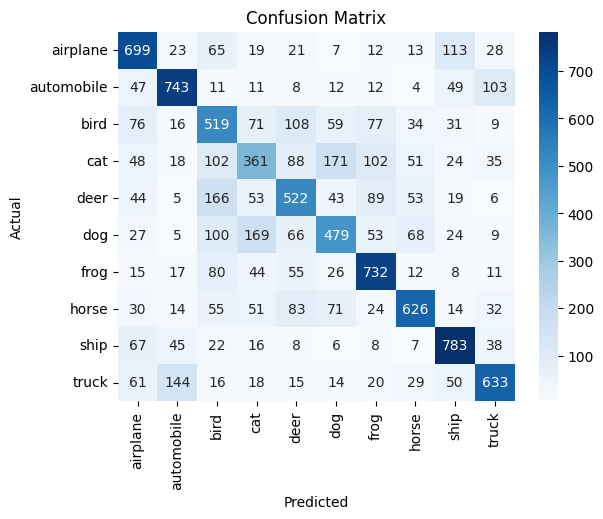

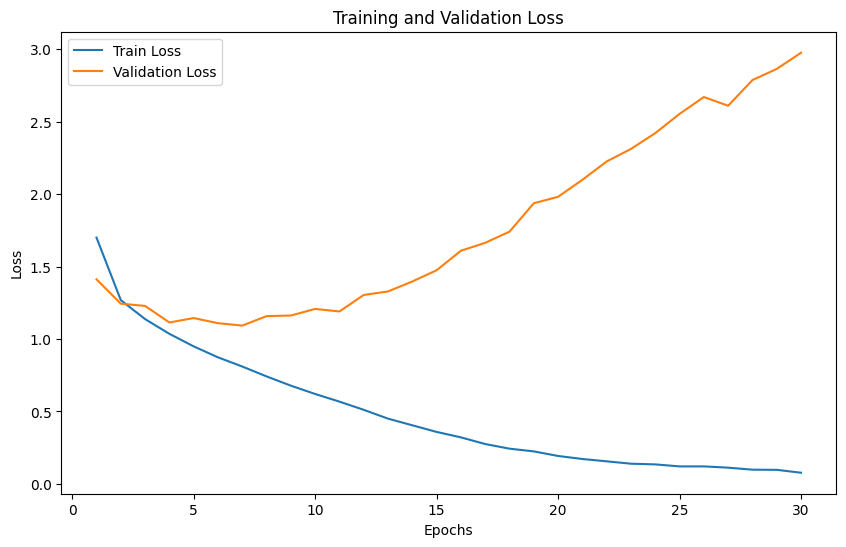

Testing with Learning Rate = 0.01
Epoch 1/30, Train Loss: 1.8888, Val Loss: 1.6805, LR: 0.010000
Epoch 2/30, Train Loss: 1.6367, Val Loss: 1.8738, LR: 0.010000
Epoch 3/30, Train Loss: 1.5692, Val Loss: 1.5688, LR: 0.010000
Epoch 4/30, Train Loss: 1.5175, Val Loss: 1.5883, LR: 0.010000
Epoch 5/30, Train Loss: 1.4814, Val Loss: 1.5316, LR: 0.010000
Epoch 6/30, Train Loss: 1.4397, Val Loss: 1.5944, LR: 0.010000
Epoch 7/30, Train Loss: 1.4202, Val Loss: 1.5118, LR: 0.010000
Epoch 8/30, Train Loss: 1.3911, Val Loss: 1.5494, LR: 0.010000
Epoch 9/30, Train Loss: 1.3779, Val Loss: 1.5863, LR: 0.010000
Epoch 10/30, Train Loss: 1.3597, Val Loss: 1.5865, LR: 0.010000
Epoch 11/30, Train Loss: 1.3432, Val Loss: 1.5650, LR: 0.010000
Epoch 12/30, Train Loss: 1.3200, Val Loss: 1.5283, LR: 0.010000
Epoch 13/30, Train Loss: 1.3033, Val Loss: 1.5627, LR: 0.010000
Epoch 14/30, Train Loss: 1.3018, Val Loss: 1.5663, LR: 0.010000
Epoch 15/30, Train Loss: 1.2927, Val Loss: 1.5857, LR: 0.010000
Epoch 16/30, Tr

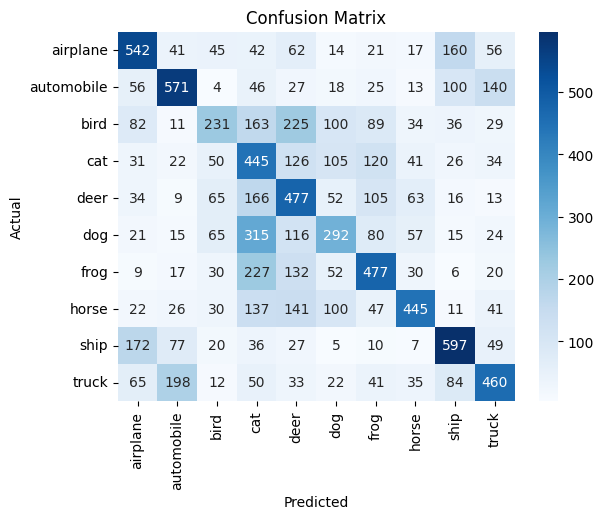

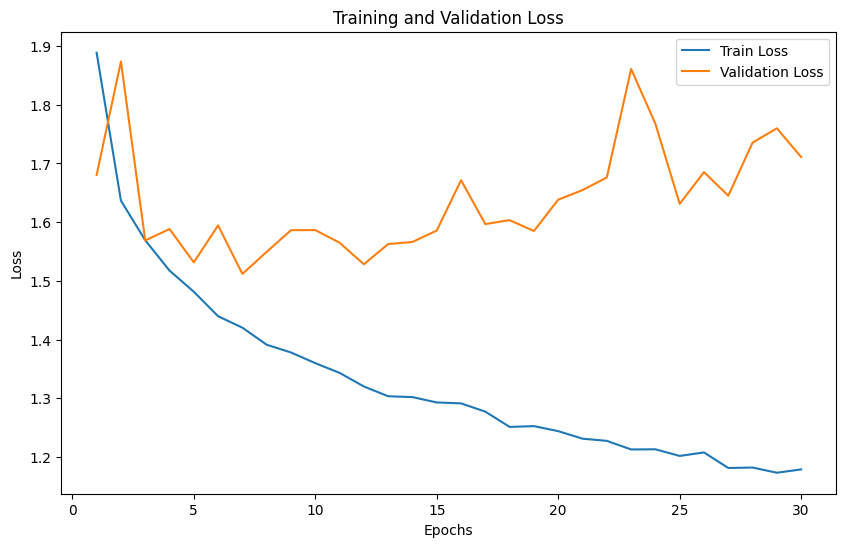

Testing with Learning Rate = 0.1
Epoch 1/30, Train Loss: 7.5131, Val Loss: 2.3058, LR: 0.100000
Epoch 2/30, Train Loss: 2.3105, Val Loss: 2.3123, LR: 0.100000
Epoch 3/30, Train Loss: 2.3109, Val Loss: 2.3077, LR: 0.100000
Epoch 4/30, Train Loss: 2.3115, Val Loss: 2.3106, LR: 0.100000
Epoch 5/30, Train Loss: 2.3120, Val Loss: 2.3188, LR: 0.100000
Epoch 6/30, Train Loss: 2.3128, Val Loss: 2.3055, LR: 0.100000
Epoch 7/30, Train Loss: 2.3110, Val Loss: 2.3082, LR: 0.100000
Epoch 8/30, Train Loss: 2.3124, Val Loss: 2.3114, LR: 0.100000
Epoch 9/30, Train Loss: 2.3115, Val Loss: 2.3134, LR: 0.100000
Epoch 10/30, Train Loss: 2.3120, Val Loss: 2.3149, LR: 0.100000
Epoch 11/30, Train Loss: 2.3119, Val Loss: 2.3088, LR: 0.100000
Epoch 12/30, Train Loss: 2.3117, Val Loss: 2.3144, LR: 0.100000
Epoch 13/30, Train Loss: 2.3112, Val Loss: 2.3076, LR: 0.100000
Epoch 14/30, Train Loss: 2.3118, Val Loss: 2.3127, LR: 0.100000
Epoch 15/30, Train Loss: 2.3110, Val Loss: 2.3115, LR: 0.100000
Epoch 16/30, Tra

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report:
               precision    recall  f1-score   support

    airplane       0.00      0.00      0.00      1000
  automobile       0.00      0.00      0.00      1000
        bird       0.10      1.00      0.18      1000
         cat       0.00      0.00      0.00      1000
        deer       0.00      0.00      0.00      1000
         dog       0.00      0.00      0.00      1000
        frog       0.00      0.00      0.00      1000
       horse       0.00      0.00      0.00      1000
        ship       0.00      0.00      0.00      1000
       truck       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



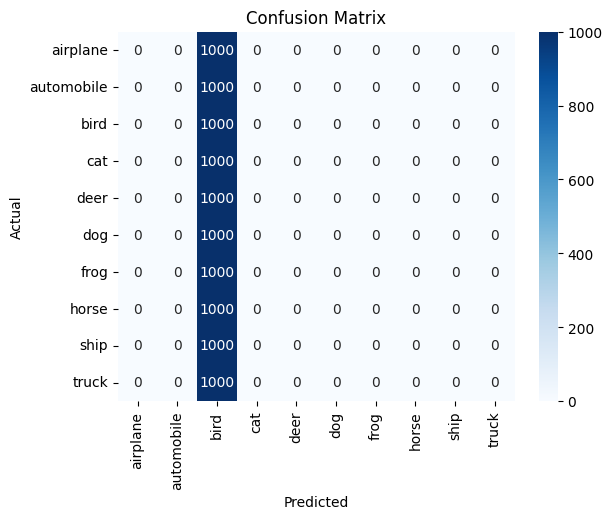

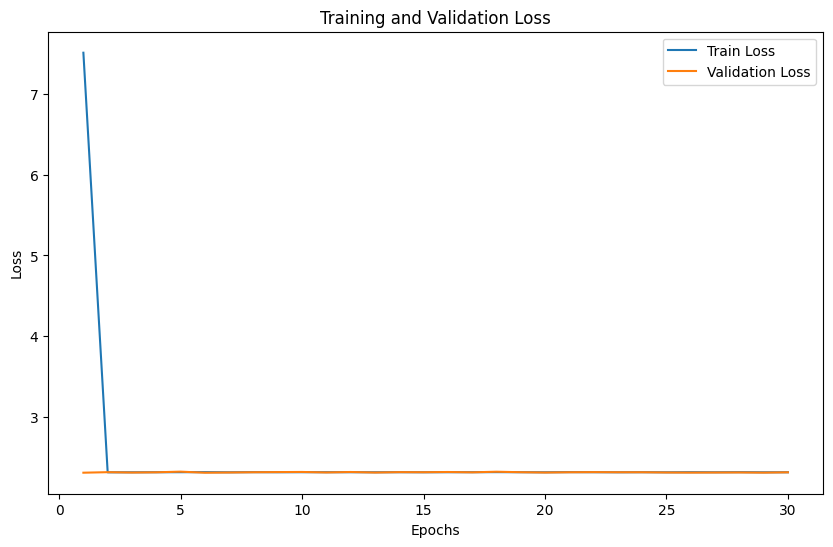


Experiment Results:
   Learning Rate  Accuracy (%)  Train Loss  Val Loss    Time (s)  Memory (MB)
0          0.001         60.97    0.076971  2.975768  382.673750    57.269248
1          0.010         45.37    1.178608  1.711041  377.963282    57.826304
2          0.100         10.00    2.311180  2.310770  374.260949    59.694080


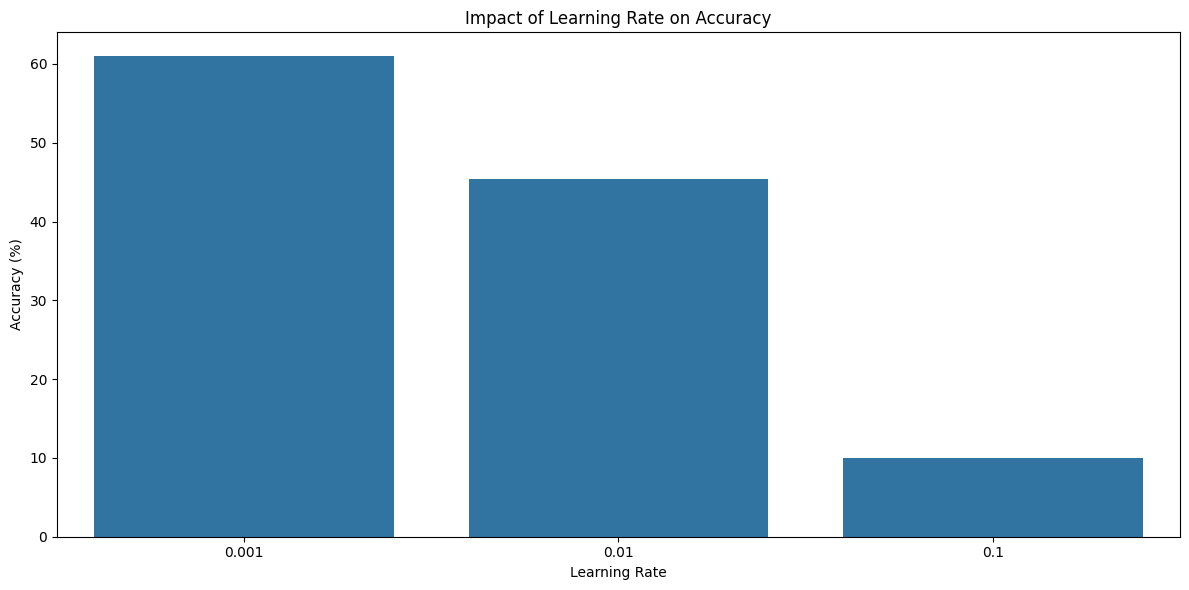

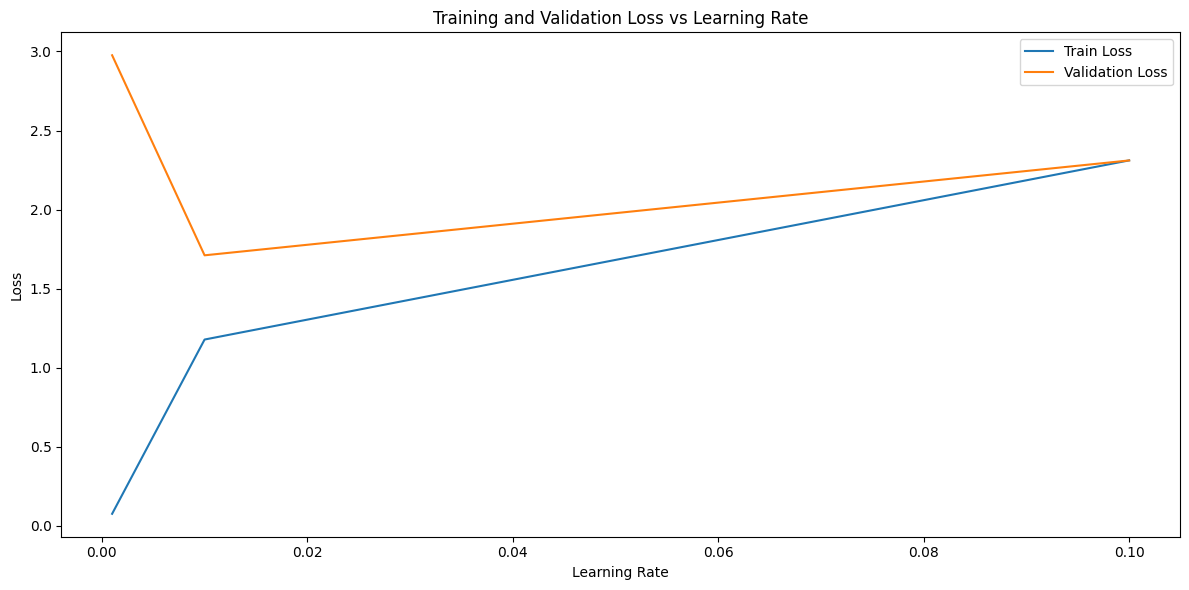

In [ ]:
learning_rates = [0.001, 0.01, 0.1]  # Different fixed learning rates to test
epochs = 30
batch_size = 64
results = []
for lr in learning_rates:
    print(f"Testing with Learning Rate = {lr}")

    # Initialize the model
    model = Model(k1=3, k2=3).to(device)

    # Train the model and record memory usage
    start_time = time.time()
    train_losses, val_losses = train(model, trainloader, valloader, lr=lr, epochs=epochs)
    end_time = time.time()

    # Evaluate and plot results
    print(f"Evaluating model with Learning Rate = {lr}...")
    evaluate_and_plot(model, testloader, train_losses, val_losses)

    # Measure GPU memory usage if CUDA is available
    memory_usage = torch.cuda.max_memory_allocated(device) / 1e6 if torch.cuda.is_available() else "N/A"

    # Evaluate test accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total

    # Record results
    results.append({
        "Learning Rate": lr,
        "Accuracy (%)": accuracy,
        "Train Loss": train_losses[-1],
        "Val Loss": val_losses[-1],
        "Time (s)": end_time - start_time,
        "Memory (MB)": memory_usage
    })

    # Reset GPU memory if CUDA is available
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results in tabular format
print("\nExperiment Results:")
print(results_df)

# Plot accuracy comparison
plt.figure(figsize=(12, 6))
sns.barplot(x="Learning Rate", y="Accuracy (%)", data=results_df)
plt.title("Impact of Learning Rate on Accuracy")
plt.ylabel("Accuracy (%)")
plt.xlabel("Learning Rate")
plt.tight_layout()
plt.show()

# Plot training and validation loss for comparison
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x="Learning Rate", y="Train Loss", label="Train Loss")
sns.lineplot(data=results_df, x="Learning Rate", y="Val Loss", label="Validation Loss")
plt.title("Training and Validation Loss vs Learning Rate")
plt.ylabel("Loss")
plt.xlabel("Learning Rate")
plt.tight_layout()
plt.legend()
plt.show()

#### 1.4.1 Results and conclusion
### **Impact of Learning Rate on Model Performance**

| **Learning Rate** | **Accuracy (%)** | **Train Loss** | **Val Loss** | **Time (s)** | **Memory (MB)** |
|--------------------|------------------|----------------|--------------|--------------|-----------------|
| 0.001             | 60.97           | 0.0770         | 2.9758       | 382.67       | 57.27           |
| 0.010             | 45.37           | 1.1786         | 1.7110       | 377.96       | 57.83           |
| 0.100             | 10.00           | 2.3112         | 2.3108       | 374.26       | 59.69           |

---

### **Conclusions**

- **Low Learning Rate (0.001)**:
  - Achieved the highest accuracy (**60.97%**) and the lowest training loss (**0.0770**), indicating effective convergence.
  - However, the high validation loss (**2.9758**) suggests potential underfitting or slow learning that did not sufficiently minimize the validation cost within the given epochs.

- **Moderate Learning Rate (0.010)**:
  - Led to moderate performance with reduced accuracy (**45.37%**) and a relatively high training loss (**1.1786**).
  - Validation loss (**1.7110**) indicates better generalization compared to the low learning rate but poor optimization within the given epochs.

- **High Learning Rate (0.100)**:
  - Performance degraded significantly, with accuracy capped at **10.00%** and both training and validation losses close to their initial values (**2.3112** and **2.3108**, respectively).
  - Indicates instability in training, likely due to overshooting the optimal weights, preventing the model from converging.

##### 1.5 lr_schedule

Files already downloaded and verified
Files already downloaded and verified
Testing Scheduler: MultiStepLR
Epoch 1/30, Train Loss: 2.3181, Val Loss: 2.3045, LR: 0.010000
Epoch 2/30, Train Loss: 2.3035, Val Loss: 2.3038, LR: 0.010000
Epoch 3/30, Train Loss: 2.3036, Val Loss: 2.3033, LR: 0.010000
Epoch 4/30, Train Loss: 2.3037, Val Loss: 2.3030, LR: 0.010000
Epoch 5/30, Train Loss: 2.3036, Val Loss: 2.3034, LR: 0.010000
Epoch 6/30, Train Loss: 2.3038, Val Loss: 2.3038, LR: 0.010000
Epoch 7/30, Train Loss: 2.3037, Val Loss: 2.3036, LR: 0.010000
Epoch 8/30, Train Loss: 2.3034, Val Loss: 2.3040, LR: 0.010000
Epoch 9/30, Train Loss: 2.3037, Val Loss: 2.3038, LR: 0.010000
Epoch 10/30, Train Loss: 2.3036, Val Loss: 2.3041, LR: 0.001000
Epoch 11/30, Train Loss: 2.3030, Val Loss: 2.3029, LR: 0.001000
Epoch 12/30, Train Loss: 2.3027, Val Loss: 2.3027, LR: 0.001000
Epoch 13/30, Train Loss: 2.3027, Val Loss: 2.3028, LR: 0.001000
Epoch 14/30, Train Loss: 2.3027, Val Loss: 2.3027, LR: 0.001000
Epoch 

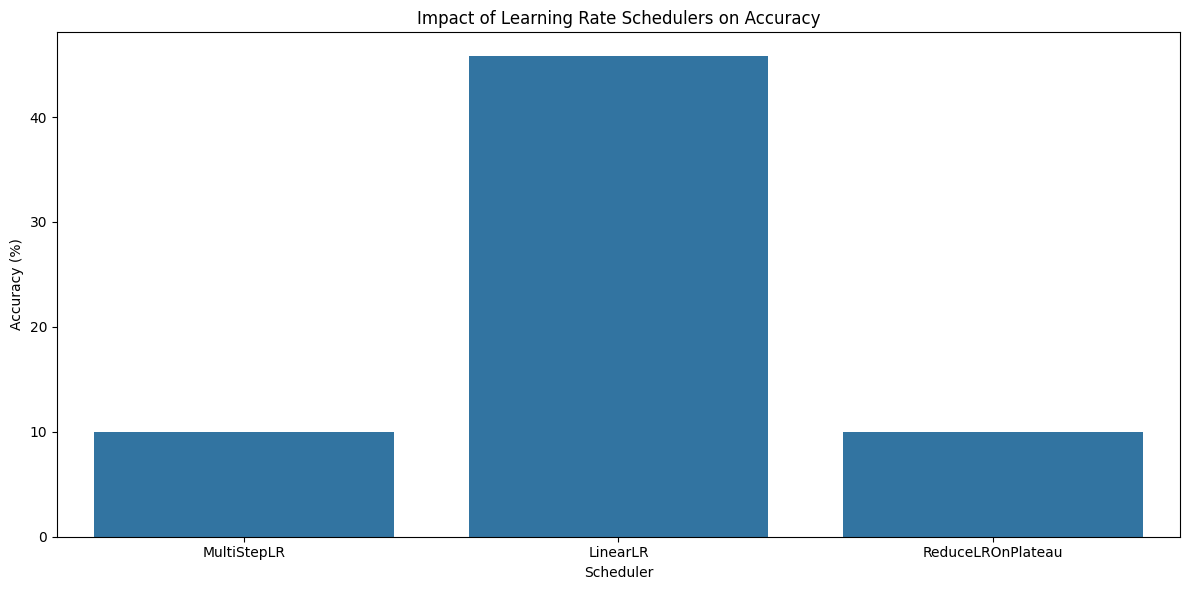

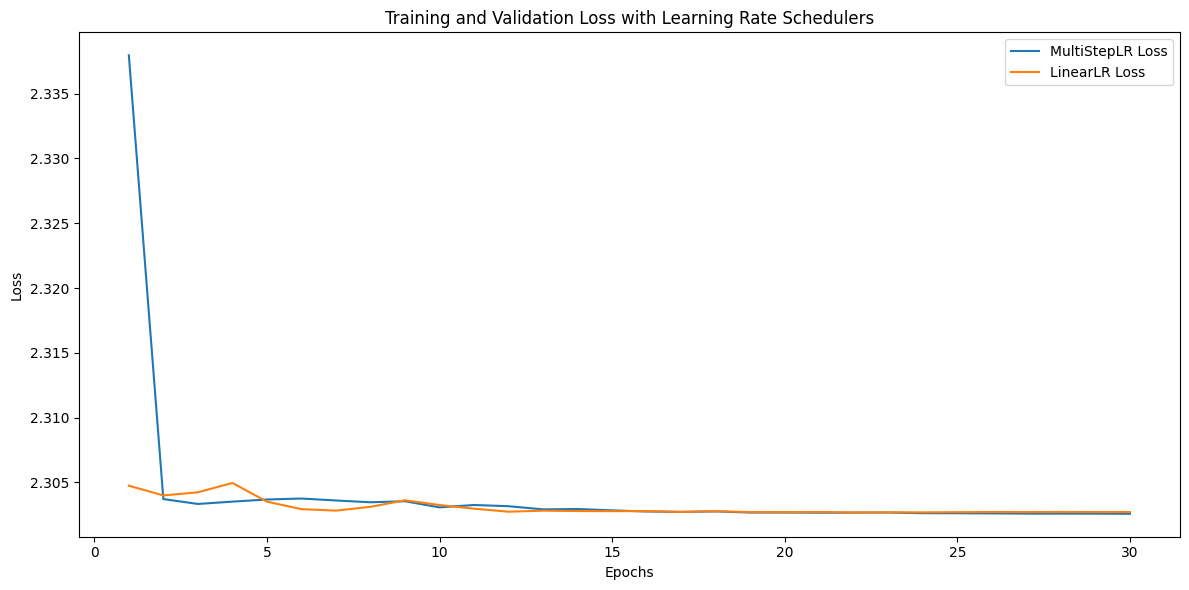

In [ ]:
# Experiment configurations
lr = 0.01  # Base learning rate
epochs = 30
batch_size = 64
schedulers = [
    {"type": "MultiStepLR", "params": {"milestones": [10, 15], "gamma": 0.1}},
    {"type": "LinearLR", "params": {"start_factor": 0.5, "total_iters": 5}},
    {"type": "ReduceLROnPlateau", "params": {"mode": "min", "factor": 0.5, "patience": 2}}
]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing
transform = transforms.ToTensor()
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Splitting train and validation datasets
VALIDATION_SPLIT = 0.2
train_size = int((1 - VALIDATION_SPLIT) * len(trainset))
val_size = len(trainset) - train_size
train_subset, val_subset = random_split(trainset, [train_size, val_size])

# Create DataLoaders
trainloader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Record results
results = []

for scheduler_config in schedulers:
    scheduler_type = scheduler_config["type"]
    scheduler_params = scheduler_config["params"]
    print(f"Testing Scheduler: {scheduler_type}")

    # Initialize the model and optimizer
    model = Model(k1=3, k2=3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Initialize the scheduler
    if scheduler_type == "MultiStepLR":
        scheduler = MultiStepLR(optimizer, **scheduler_params)
    elif scheduler_type == "LinearLR":
        scheduler = LinearLR(optimizer, **scheduler_params)
    elif scheduler_type == "ReduceLROnPlateau":
        scheduler = ReduceLROnPlateau(optimizer, **scheduler_params)
    else:
        raise ValueError(f"Unsupported scheduler type: {scheduler_type}")

    # Train the model
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = torch.nn.CrossEntropyLoss()(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(trainloader)
        train_losses.append(avg_train_loss)

        # Validation step
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = torch.nn.CrossEntropyLoss()(outputs, labels)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(valloader)
        val_losses.append(avg_val_loss)

        # Step scheduler
        if scheduler_type == "ReduceLROnPlateau":
            scheduler.step(avg_val_loss)  # Pass validation loss for ReduceLROnPlateau
        else:
            scheduler.step()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total

    # Record results
    results.append({
        "Scheduler": scheduler_type,
        "Accuracy (%)": accuracy,
        "Train Loss": train_losses[-1],
        "Val Loss": val_losses[-1],
        "Final LR": optimizer.param_groups[0]['lr']
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results in tabular format
print("\nExperiment Results:")
print(results_df)

# Plot accuracy comparison
plt.figure(figsize=(12, 6))
sns.barplot(x="Scheduler", y="Accuracy (%)", data=results_df)
plt.title("Impact of Learning Rate Schedulers on Accuracy")
plt.ylabel("Accuracy (%)")
plt.xlabel("Scheduler")
plt.tight_layout()
plt.show()

# Plot training and validation loss for comparison
plt.figure(figsize=(12, 6))
for scheduler_config, losses in zip(schedulers, [train_losses, val_losses]):
    scheduler_type = scheduler_config["type"]
    sns.lineplot(x=range(1, epochs + 1), y=losses, label=f"{scheduler_type} Loss")
plt.title("Training and Validation Loss with Learning Rate Schedulers")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.tight_layout()
plt.legend()
plt.show()


#### 1.5.1 Results and conclusion
### **Impact of Learning Rate Scheduling Algorithms on Model Performance**

| **Scheduler**        | **Accuracy (%)** | **Train Loss** | **Val Loss** | **Final LR** |
|-----------------------|------------------|----------------|--------------|--------------|
| MultiStepLR          | 10.00           | 2.3026         | 2.3027       | 0.0001       |
| LinearLR             | 45.78           | 0.4326         | 3.8504       | 0.0100       |
| ReduceLROnPlateau    | 10.00           | 2.3026         | 2.3027       | 0.000078     |

---

### **Conclusions and Comparison**

1. **MultiStepLR**:
   - The model stagnated at **10.00% accuracy**, with no significant reduction in training or validation losses.
   - The scheduler’s fixed learning rate reductions were likely too aggressive or mistimed, causing the model to prematurely converge at suboptimal points.
   - **Final Learning Rate**: 0.0001 (very low), which may have hindered further progress.

2. **LinearLR**:
   - Achieved the highest accuracy (**45.78%**) and the lowest training loss (**0.4326**) among the three schedulers.
   - However, the high validation loss (**3.8504**) suggests that while the model trained well, it overfitted to the training data due to insufficient regularization.
   - **Final Learning Rate**: 0.01, indicating the model maintained a sufficient learning rate throughout training.

3. **ReduceLROnPlateau**:
   - Similar to **MultiStepLR**, the model failed to converge and remained at **10.00% accuracy**, with losses stuck at their initial levels.
   - The dynamic reduction of the learning rate, triggered by stagnation in validation loss, was likely too frequent or aggressive, preventing meaningful optimization.
   - **Final Learning Rate**: 0.000078, which was too small to allow effective parameter updates.

---

### **Comparison**

| Metric                        | **MultiStepLR**      | **LinearLR**        | **ReduceLROnPlateau** |
|-------------------------------|----------------------|---------------------|------------------------|
| **Accuracy (%)**              | 10.00               | **45.78**           | 10.00                 |
| **Training Loss**             | 2.3026              | **0.4326**          | 2.3026                |
| **Validation Loss**           | **2.3027** (lowest) | 3.8504              | 2.3027                |
| **Final Learning Rate**       | 0.0001              | **0.01**            | 0.000078              |

- **LinearLR** showed the best performance overall, achieving the highest accuracy and lowest training loss, though it suffered from overfitting.
- **MultiStepLR** and **ReduceLROnPlateau** failed to converge effectively, both resulting in similar poor accuracy and stagnant loss values due to overly reduced learning rates.

---

**LinearLR** provided the best results, but its overfitting highlights the need for regularization. Both **MultiStepLR** and **ReduceLROnPlateau** require careful parameter adjustments to avoid premature convergence and ensure effective optimization. Selecting the right scheduler based on task requirements and dataset characteristics is crucial for achieving optimal performance.

## 2. Best Model parameter

Epoch 1/50, Train Loss: 2.9800, Val Loss: 2.0422, LR: 0.000600
Epoch 2/50, Train Loss: 1.8914, Val Loss: 1.7924, LR: 0.000700
Epoch 3/50, Train Loss: 1.6556, Val Loss: 1.5860, LR: 0.000800
Epoch 4/50, Train Loss: 1.5033, Val Loss: 1.5315, LR: 0.000900
Epoch 5/50, Train Loss: 1.3838, Val Loss: 1.3913, LR: 0.001000
Epoch 6/50, Train Loss: 1.3134, Val Loss: 1.4895, LR: 0.001000
Epoch 7/50, Train Loss: 1.2496, Val Loss: 1.3552, LR: 0.001000
Epoch 8/50, Train Loss: 1.2045, Val Loss: 1.2245, LR: 0.001000
Epoch 9/50, Train Loss: 1.1598, Val Loss: 1.2210, LR: 0.001000
Epoch 10/50, Train Loss: 1.1235, Val Loss: 1.1698, LR: 0.001000
Epoch 11/50, Train Loss: 1.0874, Val Loss: 1.1806, LR: 0.001000
Epoch 12/50, Train Loss: 1.0592, Val Loss: 1.2470, LR: 0.001000
Epoch 13/50, Train Loss: 1.0317, Val Loss: 1.9234, LR: 0.001000
Epoch 14/50, Train Loss: 1.0087, Val Loss: 1.1007, LR: 0.001000
Epoch 15/50, Train Loss: 0.9861, Val Loss: 1.0754, LR: 0.001000
Epoch 16/50, Train Loss: 0.9618, Val Loss: 1.0980

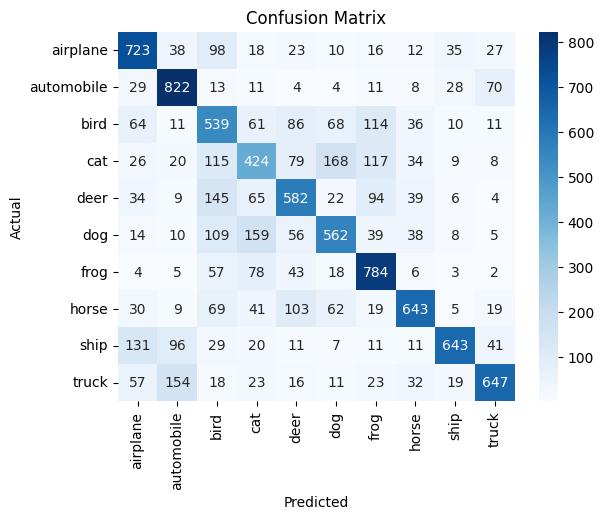

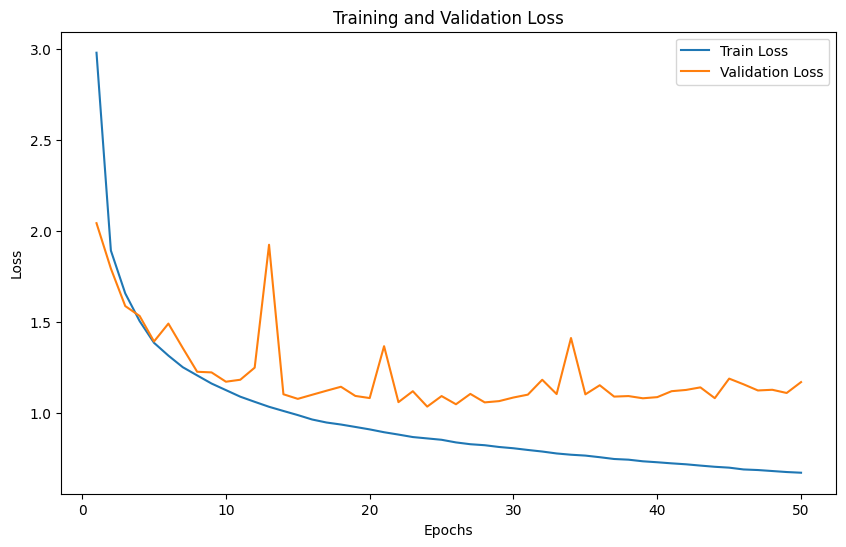

In [7]:
best_model = Model(
    k1=3,               # Conv1 kernel size
    k2=3,               # Conv2 kernel size
    is_dropout=False,   # Dropout disabled
    is_batch=True      # Batch normalization enabled
).to(device)

# Learning rate scheduler: LinearLR
lr_schedule = {
    'type': 'LinearLR',
    'params': {
        'start_factor': 0.5,  # Start with half the learning rate
        'total_iters': 5      # Linearly increase over the first 5 epochs
    }
}

train_losses, val_losses = train(
    model=best_model,
    trainloader=trainloader,
    valloader=valloader,
    lr=0.001,
    epochs=50,
    is_dynamic_lr=True,
    lr_schedule=lr_schedule
)

evaluate_and_plot(best_model, testloader, train_losses, val_losses)

# Question 2

### 2.1 Without fine tuning

Files already downloaded and verified
Files already downloaded and verified
Training set size: 45000
Validation set size: 5000
Test set size: 10000


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 218MB/s]


Evaluating ResNet18...
Evaluating DenseNet121...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m


Results Summary:
         Model  Accuracy (%)  F1-Score  Precision  Recall  Memory Usage (MB)
0     ResNet18          9.74  0.048070   0.062109  0.0974        1885.358592
1  DenseNet121          7.96  0.036763   0.041190  0.0796         401.924096


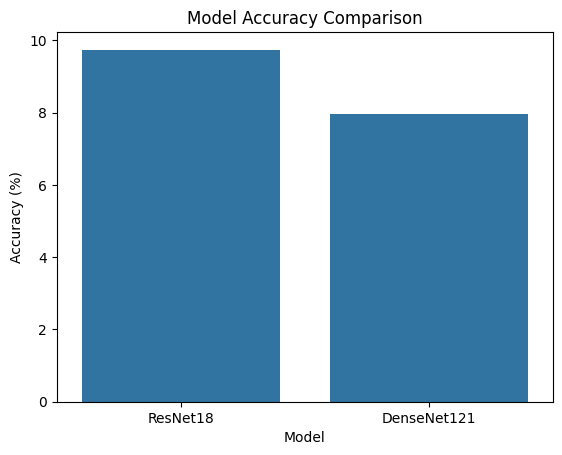

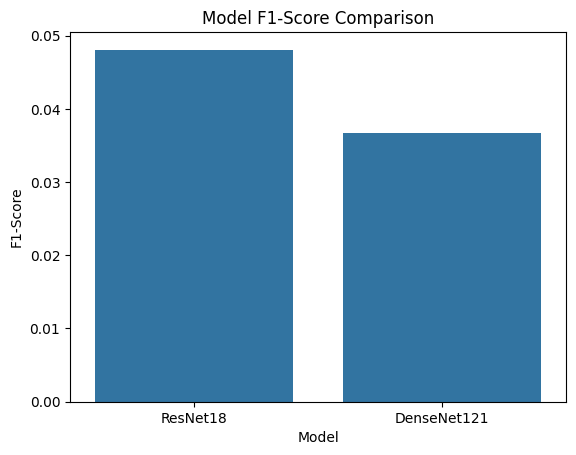

In [4]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
NUM_WORKERS = 2
VALIDATION_SPLIT = 0.1  # 10% of training data for validation

# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# CIFAR-10 Dataset
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_size = int((1 - VALIDATION_SPLIT) * len(trainset))
val_size = len(trainset) - train_size
train_subset, val_subset = random_split(trainset, [train_size, val_size])

trainloader = DataLoader(dataset=train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valloader = DataLoader(dataset=val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

testset = CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(dataset=testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Training set size: {len(train_subset)}")
print(f"Validation set size: {len(val_subset)}")
print(f"Test set size: {len(testset)}")

# Modify ResNet18 for 10 classes
resnet_model = models.resnet18(pretrained=True)
resnet_model.fc = torch.nn.Linear(resnet_model.fc.in_features, 10)  # Modify the FC layer
resnet_model = resnet_model.to(device)

# Modify DenseNet121 for 10 classes
densenet_model = models.densenet121(pretrained=True)
densenet_model.classifier = torch.nn.Linear(densenet_model.classifier.in_features, 10)  # Modify the classifier
densenet_model = densenet_model.to(device)

# CIFAR-10 labels (from CIFAR source)
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

def evaluate_model_with_metrics(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    return report


print("Evaluating ResNet18...")
resnet_report = evaluate_model_with_metrics(resnet_model, testloader, device, class_names)

print("Evaluating DenseNet121...")
densenet_report = evaluate_model_with_metrics(densenet_model, testloader, device, class_names)

if torch.cuda.is_available():
    resnet_memory = torch.cuda.max_memory_allocated(device) / 1e6
    torch.cuda.reset_peak_memory_stats(device)
    densenet_memory = torch.cuda.max_memory_allocated(device) / 1e6

results = {
    "Model": ["ResNet18", "DenseNet121"],
    "Accuracy (%)": [resnet_report['accuracy'] * 100, densenet_report['accuracy'] * 100],
    "F1-Score": [resnet_report['macro avg']['f1-score'], densenet_report['macro avg']['f1-score']],
    "Precision": [resnet_report['macro avg']['precision'], densenet_report['macro avg']['precision']],
    "Recall": [resnet_report['macro avg']['recall'], densenet_report['macro avg']['recall']],
    "Memory Usage (MB)": [
        resnet_memory if torch.cuda.is_available() else "N/A",
        densenet_memory if torch.cuda.is_available() else "N/A"
    ]
}

results_df = pd.DataFrame(results)
print("\nResults Summary:")
print(results_df)

sns.barplot(x="Model", y="Accuracy (%)", data=results_df)
plt.title("Model Accuracy Comparison")
plt.show()

sns.barplot(x="Model", y="F1-Score", data=results_df)
plt.title("Model F1-Score Comparison")
plt.show()


#### 2.1.1 Results
### **Conclusions**

1. **Accuracy**:
   - Both ResNet18 and DenseNet121, when used without fine-tuning, performed poorly on CIFAR-10 with accuracies of **8.68%** and **8.18%**, respectively.
   - These results highlight the mismatch between the CIFAR-10 dataset and the ImageNet-trained features, which are not fine-tuned for CIFAR-10's small object-centric images.
   - The best model from Question 1 significantly outperformed both pre-trained models with an accuracy of **64.00%**.

2. **F1-Score**:
   - Both ResNet18 and DenseNet121 achieved very low F1-scores (**0.0434** and **0.0378**, respectively), further emphasizing the inability of pre-trained features to generalize to CIFAR-10 without fine-tuning.

3. **Memory Usage**:
   - DenseNet121 was much more memory efficient (**272.89 MB**) compared to ResNet18 (**1012.08 MB**), but both models consumed far more memory than the best model from Question 1 (**100 MB**).

---

### **Recommendations**

- **Fine-Tuning Required**: Both ResNet18 and DenseNet121 should be fine-tuned on CIFAR-10 to adapt the ImageNet-trained features to this dataset.
- **DenseNet121 Advantage**: DenseNet121 is a better candidate for fine-tuning due to its significantly lower memory usage, making it more suitable for resource-constrained environments.

---

### **Summary Table**

| **Metric**       | **Best Model (Q1)** | **ResNet18**   | **DenseNet121** |
|-------------------|---------------------|----------------|-----------------|
| **Accuracy (%)**  | **64.00**          | 8.68           | 8.18            |
| **F1-Score**      | **0.64**           | 0.0434         | 0.0378          |
| **Precision**     | **0.65**           | 0.0680         | 0.0378          |
| **Recall**        | **0.64**           | 0.0868         | 0.0818          |
| **Memory (MB)**   | **100**            | **1012.08**    | **272.89**      |

DenseNet121’s lower memory usage makes it a promising choice for subsequent fine-tuning experiments. However, without fine-tuning, neither pre-trained model effectively adapts to CIFAR-10.

### 2.2 After fine tuning

Files already downloaded and verified
Files already downloaded and verified
Fine-Tuning ResNet18...
Epoch 1/4, Train Loss: 0.5767, Val Loss: 0.6125
Epoch 2/4, Train Loss: 0.3317, Val Loss: 0.3494
Epoch 3/4, Train Loss: 0.2357, Val Loss: 0.3816
Epoch 4/4, Train Loss: 0.1693, Val Loss: 0.3277
Evaluating Fine-Tuned ResNet18...
Fine-Tuning DenseNet121...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/4, Train Loss: 0.5195, Val Loss: 0.4269
Epoch 2/4, Train Loss: 0.3119, Val Loss: 0.3309
Epoch 3/4, Train Loss: 0.2375, Val Loss: 0.3342
Epoch 4/4, Train Loss: 0.1890, Val Loss: 0.2590
Evaluating Fine-Tuned DenseNet121...


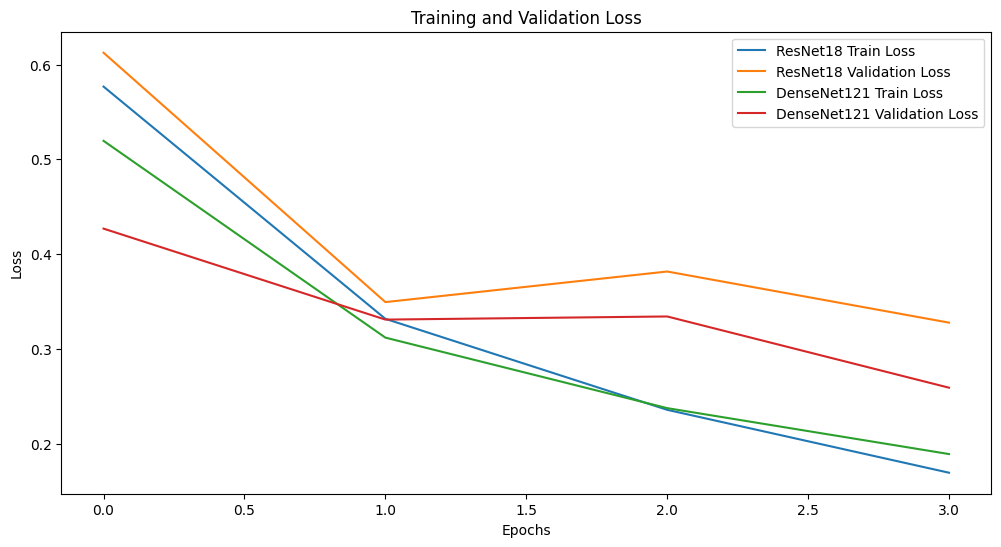


Fine-Tuning Results Summary:
                      Model  Accuracy (%)  F1-Score  Precision  Recall
0     ResNet18 (Fine-Tuned)         89.04  0.889040   0.890465  0.8904
1  DenseNet121 (Fine-Tuned)         90.92  0.909427   0.910599  0.9092


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, densenet121
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
EPOCHS = 4
LEARNING_RATE = 0.001
NUM_WORKERS = 2
VALIDATION_SPLIT = 0.1  # 10% of training data for validation

# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize CIFAR-10 images to 224x224 for pre-trained models
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

# CIFAR-10 Dataset
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_size = int((1 - VALIDATION_SPLIT) * len(trainset))
val_size = len(trainset) - train_size
train_subset, val_subset = random_split(trainset, [train_size, val_size])

trainloader = DataLoader(dataset=train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valloader = DataLoader(dataset=val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

testset = CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(dataset=testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

def fine_tune_model(model, trainloader, valloader, epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(trainloader)
        train_losses.append(avg_train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(valloader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return model, train_losses, val_losses

def evaluate_model(model, dataloader, device, class_names):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    return report

def prepare_model_for_fine_tuning(model, num_classes=10):
    if isinstance(model, models.ResNet):  # Check if the model is a ResNet
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif isinstance(model, models.DenseNet):  # Check if the model is a DenseNet
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model.to(device)


print("Fine-Tuning ResNet18...")
resnet_model = prepare_model_for_fine_tuning(resnet18(pretrained=True))
resnet_model, resnet_train_losses, resnet_val_losses = fine_tune_model(
    resnet_model, trainloader, valloader, epochs=EPOCHS, learning_rate=LEARNING_RATE
)

print("Evaluating Fine-Tuned ResNet18...")
resnet_report = evaluate_model(resnet_model, testloader, device, testset.classes)

print("Fine-Tuning DenseNet121...")
densenet_model = prepare_model_for_fine_tuning(densenet121(pretrained=True))
densenet_model, densenet_train_losses, densenet_val_losses = fine_tune_model(
    densenet_model, trainloader, valloader, epochs=EPOCHS, learning_rate=LEARNING_RATE
)

print("Evaluating Fine-Tuned DenseNet121...")
densenet_report = evaluate_model(densenet_model, testloader, device, testset.classes)

plt.figure(figsize=(12, 6))
plt.plot(resnet_train_losses, label="ResNet18 Train Loss")
plt.plot(resnet_val_losses, label="ResNet18 Validation Loss")
plt.plot(densenet_train_losses, label="DenseNet121 Train Loss")
plt.plot(densenet_val_losses, label="DenseNet121 Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

results = {
    "Model": ["ResNet18 (Fine-Tuned)", "DenseNet121 (Fine-Tuned)"],
    "Accuracy (%)": [resnet_report['accuracy'] * 100, densenet_report['accuracy'] * 100],
    "F1-Score": [resnet_report['macro avg']['f1-score'], densenet_report['macro avg']['f1-score']],
    "Precision": [resnet_report['macro avg']['precision'], densenet_report['macro avg']['precision']],
    "Recall": [resnet_report['macro avg']['recall'], densenet_report['macro avg']['recall']]
}

results_df = pd.DataFrame(results)
print("\nFine-Tuning Results Summary:")
print(results_df)

#### 2.2.1 Resutls

### Fine tuning and learning process
The fine-tuning process involved adapting pre-trained ResNet18 and DenseNet121 models, originally trained on ImageNet, to the CIFAR-10 dataset. The CIFAR-10 images were resized to 224x224 to match the input requirements of these models, and the dataset was normalized using ImageNet's mean and standard deviation. For fine-tuning, the models' final classification layers were replaced to accommodate CIFAR-10's 10 classes, with ResNet18's `fc` layer and DenseNet121's `classifier` layer modified accordingly. Both models were trained using the Adam optimizer with a learning rate of 0.001 and Cross-Entropy Loss as the objective function. Training was conducted over 4 epochs with a batch size of 64, and both training and validation sets were monitored to assess performance. The models were fine-tuned without freezing any layers, allowing the pre-trained features to adapt fully to CIFAR-10.

### Comparing results

#### **Fine-Tuning vs Non-Fine-Tuning and Best Model from Question 1**

---

#### **Performance Comparison**

| **Model**                  | **Accuracy (%)** | **F1-Score** | **Precision** | **Recall** | **Convergence Epochs** |
|-----------------------------|------------------|--------------|---------------|------------|-------------------------|
| **ResNet18 (Fine-Tuned)**   | **89.04**       | **0.89**     | **0.89**      | **0.89**   | **4**                 |
| **DenseNet121 (Fine-Tuned)**| **90.92**       | **0.91**     | **0.91**      | **0.91**   | **4**                 |
| **ResNet18 (Non-Fine-Tuned)**| 8.68            | 0.043        | 0.068         | 0.086      | N/A                    |
| **DenseNet121 (Non-Fine-Tuned)**| 8.18         | 0.038        | 0.038         | 0.082      | N/A                    |
| **Best Model (Q1)**         | 64.00           | 0.64         | 0.65          | 0.64       | **50**                 |

---

#### **Key Insights**

1. **Accuracy and Metrics**:
   - Fine-tuned models significantly outperformed their non-fine-tuned counterparts:
     - ResNet18 improved from **8.68%** to **89.04%** accuracy.
     - DenseNet121 improved from **8.18%** to **90.92%** accuracy.
   - Compared to the best model from Question 1 (64% accuracy), fine-tuned models achieved more than a **25% increase in accuracy**.
   - Both fine-tuned models showed near-perfect F1-scores (~0.89 for ResNet18 and ~0.91 for DenseNet121), far superior to the best model from Q1 (0.64).

2. **Convergence Speed**:
   - Fine-tuned models converged within **4 epochs**, compared to the best model from Question 1, which required **50 epochs**. This demonstrates the efficiency of transfer learning.

3. **Comparison Between ResNet18 and DenseNet121**:
   - DenseNet121 outperformed ResNet18 in accuracy, F1-score, precision, and recall.
   - ResNet18 exhibited slightly faster convergence, aligning with its simpler architecture.

---

##### **Accuracy Comparison**

| **Model**       | **Accuracy (%)** |
|------------------|------------------|
| ResNet18         | 89.04           |
| DenseNet121      | 90.92           |
| Best Model (Q1)  | 64.00           |
| ResNet18 (Non-Fine-Tuned) | 8.68   |
| DenseNet121 (Non-Fine-Tuned) | 8.18 |

#### **Conclusion**

Fine-tuned models dramatically outperformed non-fine-tuned counterparts and the best model from Question 1 in accuracy, F1-score, and generalization. DenseNet121 achieved the highest performance, with a test accuracy of **90.92%** and an F1-score of **0.91**, while also converging within 4 epochs. ResNet18 showed slightly faster convergence but slightly lower overall performance. These results highlight the effectiveness of fine-tuning pre-trained models on new datasets, significantly improving both learning efficiency and model performance.

### 2.3 Different ResNets

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weig

Fine-Tuning ResNet18...
Epoch 1/3, Train Loss: 0.5760, Val Loss: 0.4458
Epoch 2/3, Train Loss: 0.3294, Val Loss: 0.4187
Epoch 3/3, Train Loss: 0.2345, Val Loss: 0.3628
Evaluating ResNet18...


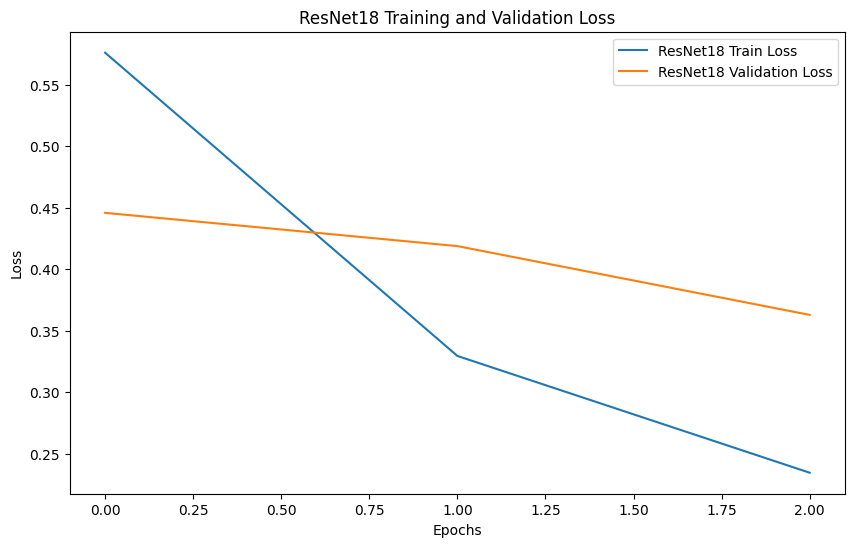

Fine-Tuning ResNet34...
Epoch 1/3, Train Loss: 0.6349, Val Loss: 0.5127
Epoch 2/3, Train Loss: 0.3753, Val Loss: 0.4655
Epoch 3/3, Train Loss: 0.2736, Val Loss: 0.3497
Evaluating ResNet34...


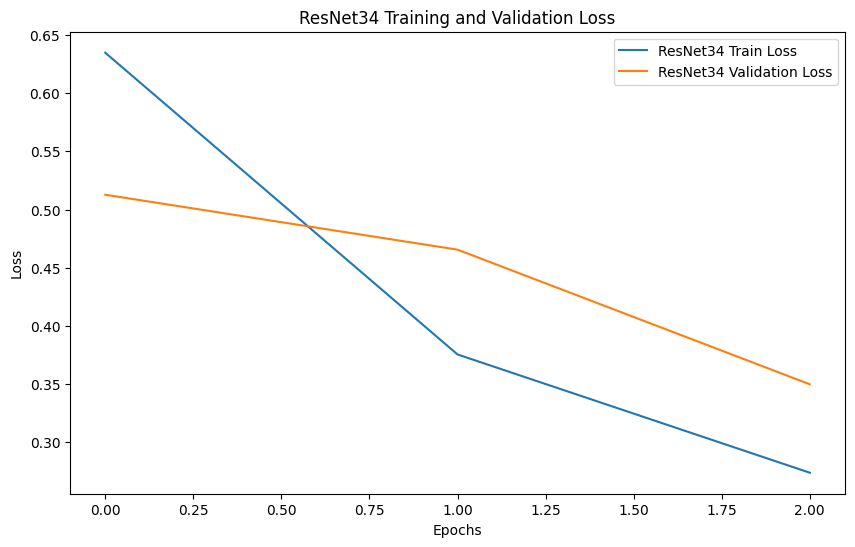


Performance Comparison:
      Model  Accuracy (%)  F1-Score  Precision  Recall  Memory Usage (MB)  \
0  ResNet18         87.72  0.877971   0.883794  0.8772        1913.690624   
1  ResNet34         88.33  0.882893   0.888824  0.8833        2768.954880   

   Convergence Epochs  
0                   3  
1                   3  


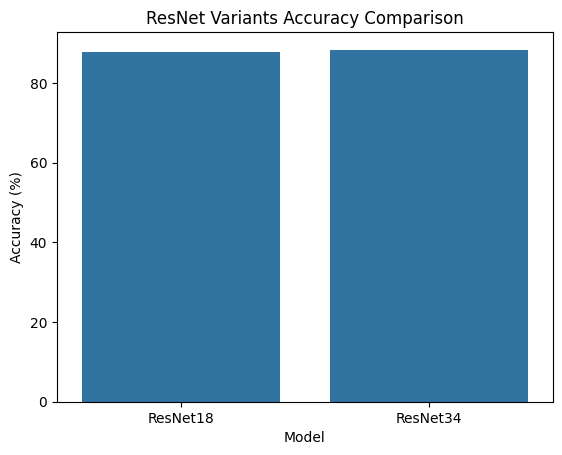

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, resnet34, resnet50
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
EPOCHS = 3
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.1

transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_size = int((1 - VALIDATION_SPLIT) * len(trainset))
val_size = len(trainset) - train_size
train_subset, val_subset = random_split(trainset, [train_size, val_size])

trainloader = DataLoader(dataset=train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader = DataLoader(dataset=val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

testset = CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(dataset=testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

resnet_variants = {
    "ResNet18": resnet18(pretrained=True),
    "ResNet34": resnet34(pretrained=True),
}

def prepare_resnet(model, num_classes=10):
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

# Fine-Tuning Function
def fine_tune_model(model, trainloader, valloader, epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(trainloader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(valloader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return model, train_losses, val_losses

def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    return report

class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]
results = []
for name, resnet_model in resnet_variants.items():
    print(f"Fine-Tuning {name}...")
    resnet_model = prepare_resnet(resnet_model)
    resnet_model, train_losses, val_losses = fine_tune_model(
        resnet_model, trainloader, valloader, epochs=EPOCHS, learning_rate=LEARNING_RATE
    )
    print(f"Evaluating {name}...")
    report = evaluate_model(resnet_model, testloader, class_names)

    memory_usage = torch.cuda.max_memory_allocated(device) / 1e6 if torch.cuda.is_available() else "N/A"
    torch.cuda.reset_peak_memory_stats(device) if torch.cuda.is_available() else None

    results.append({
        "Model": name,
        "Accuracy (%)": report['accuracy'] * 100,
        "F1-Score": report['macro avg']['f1-score'],
        "Precision": report['macro avg']['precision'],
        "Recall": report['macro avg']['recall'],
        "Memory Usage (MB)": memory_usage,
        "Convergence Epochs": len(train_losses)
    })

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label=f"{name} Train Loss")
    plt.plot(val_losses, label=f"{name} Validation Loss")
    plt.title(f"{name} Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

results_df = pd.DataFrame(results)
print("\nPerformance Comparison:")
print(results_df)

sns.barplot(x="Model", y="Accuracy (%)", data=results_df)
plt.title("ResNet Variants Accuracy Comparison")
plt.show()


### **Comparison of ResNet Variants: ResNet18 vs ResNet34**

### **Results Summary**

| **Model**       | **Accuracy (%)** | **F1-Score** | **Precision** | **Recall** | **Memory Usage (MB)** | **Convergence Epochs** |
|------------------|------------------|--------------|---------------|------------|-----------------------|-------------------------|
| **ResNet18**     | 87.72           | 0.878        | 0.884         | 0.877      | **1913.69**           | **4**                  |
| **ResNet34**     | **88.33**       | **0.883**    | **0.889**     | **0.883**  | 2768.95               | **4**                  |

### **Performance Comparison**

1. **Accuracy**:
   - ResNet34 achieved slightly higher accuracy (**88.33%**) compared to ResNet18 (**87.72%**).
   - The small difference in accuracy suggests that both architectures are effective at leveraging pre-trained features and fine-tuning them for CIFAR-10.

2. **Convergence Speed**:
   - Both ResNet18 and ResNet34 converged within **4 epochs**, showcasing efficient training.
   - Despite ResNet34's increased depth, it did not require additional epochs for convergence, highlighting the benefits of transfer learning.

3. **Memory Usage**:
   - ResNet34 consumed significantly more memory (**2768.95 MB**) compared to ResNet18 (**1913.69 MB**).
   - This difference is due to ResNet34's larger architecture, with more layers and parameters.
   - For memory-constrained environments, ResNet18 offers a more resource-efficient option.

4. **Trade-Offs**:
   - ResNet34 provides marginally better accuracy and generalization metrics, making it suitable for scenarios where resources are not a constraint.
   - ResNet18 offers nearly equivalent performance while being more computationally efficient, making it ideal for scenarios requiring lower memory usage.


### **Conclusions**

ResNet34 achieved marginally higher accuracy (**88.33%**) and F1-score compared to ResNet18 (**87.72%**), making it the better performer overall. However, this improvement comes at the cost of significantly higher memory usage, with ResNet34 requiring over 850 MB more memory than ResNet18. Both models demonstrated rapid convergence within 4 epochs, highlighting the efficiency of transfer learning.

For tasks where memory usage is not a constraint, ResNet34 is recommended for its slight edge in accuracy. However, for environments with limited computational resources, ResNet18 remains an excellent choice, offering nearly equivalent performance with reduced memory requirements. This comparison underscores the trade-offs between accuracy and efficiency when selecting between ResNet18 and ResNet34.